# Building a Model for Spotify Streaming Data

**Collaborators**: Benjamin Pierce, Jillian Fernau, Abigail Lussier,  Jackson Lawrence

**Date**: 10/29/2023

**Data Source**: https://www.kaggle.com/datasets/nelgiriyewithana/top-spotify-songs-2023/

#### Note: This Notebook takes around 25 minutes to fully run

In [1]:
import pandas as pd
import numpy as np
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

## EDA

In [2]:
#load data from a csv file
spotify_df = pd.read_csv('spotify-2023.csv', encoding='unicode_escape')
pd.set_option('display.max_columns',None) #so that I can see every column
spotify_df.head() #looks good!

,track_name,artist(s)_name,artist_count,released_year,released_month,released_day,in_spotify_playlists,in_spotify_charts,streams,in_apple_playlists,in_apple_charts,in_deezer_playlists,in_deezer_charts,in_shazam_charts,bpm,key,mode,danceability_%,valence_%,energy_%,acousticness_%,instrumentalness_%,liveness_%,speechiness_%
0,Seven (feat. Latto) (Explicit Ver.),"Latto, Jung Kook",2,2023,7,14,553,147,141381703,43,263,45,10,826,125,B,Major,80,89,83,31,0,8,4
1,LALA,Myke Towers,1,2023,3,23,1474,48,133716286,48,126,58,14,382,92,C#,Major,71,61,74,7,0,10,4
2,vampire,Olivia Rodrigo,1,2023,6,30,1397,113,140003974,94,207,91,14,949,138,F,Major,51,32,53,17,0,31,6
3,Cruel Summer,Taylor Swift,1,2019,8,23,7858,100,800840817,116,207,125,12,548,170,A,Major,55,58,72,11,0,11,15
4,WHERE SHE GOES,Bad Bunny,1,2023,5,18,3133,50,303236322,84,133,87,15,425,144,A,Minor,65,23,80,14,63,11,6


In [3]:
#check the frequency of null values in each column
spotify_df.isnull().sum()
# some in shazam and key, otherwise not an issue

track_name               0
artist(s)_name           0
artist_count             0
released_year            0
released_month           0
released_day             0
in_spotify_playlists     0
in_spotify_charts        0
streams                  0
in_apple_playlists       0
in_apple_charts          0
in_deezer_playlists      0
in_deezer_charts         0
in_shazam_charts        50
bpm                      0
key                     95
mode                     0
danceability_%           0
valence_%                0
energy_%                 0
acousticness_%           0
instrumentalness_%       0
liveness_%               0
speechiness_%            0
dtype: int64

In [4]:
spotify_df.info()
#most of these values look good, but going to make track, artists names, 
#key, and mode into strings 
#and streams needs to be an integer
#ISSUE FOUND: One of the stream values is not a integer, the data entry was messed up
#going to remove that row
spotify_df = spotify_df.drop(574, axis=0)

# address null key values with imputation
spotify_df['key'] = spotify_df['key'].fillna('Unknown')

spotify_df['track_name']  = spotify_df['track_name'].astype('string')
spotify_df['artist(s)_name']  = spotify_df['artist(s)_name'].astype('string')
spotify_df['key']  = spotify_df['key'].astype('string')
spotify_df['mode']  = spotify_df['mode'].astype('string')
spotify_df['streams']  = spotify_df['streams'].astype('int64')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 953 entries, 0 to 952
Data columns (total 24 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   track_name            953 non-null    object
 1   artist(s)_name        953 non-null    object
 2   artist_count          953 non-null    int64 
 3   released_year         953 non-null    int64 
 4   released_month        953 non-null    int64 
 5   released_day          953 non-null    int64 
 6   in_spotify_playlists  953 non-null    int64 
 7   in_spotify_charts     953 non-null    int64 
 8   streams               953 non-null    object
 9   in_apple_playlists    953 non-null    int64 
 10  in_apple_charts       953 non-null    int64 
 11  in_deezer_playlists   953 non-null    object
 12  in_deezer_charts      953 non-null    int64 
 13  in_shazam_charts      903 non-null    object
 14  bpm                   953 non-null    int64 
 15  key                   858 non-null    ob

In [5]:
spotify_df.info() #looks better!

<class 'pandas.core.frame.DataFrame'>
Index: 952 entries, 0 to 952
Data columns (total 24 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   track_name            952 non-null    string
 1   artist(s)_name        952 non-null    string
 2   artist_count          952 non-null    int64 
 3   released_year         952 non-null    int64 
 4   released_month        952 non-null    int64 
 5   released_day          952 non-null    int64 
 6   in_spotify_playlists  952 non-null    int64 
 7   in_spotify_charts     952 non-null    int64 
 8   streams               952 non-null    int64 
 9   in_apple_playlists    952 non-null    int64 
 10  in_apple_charts       952 non-null    int64 
 11  in_deezer_playlists   952 non-null    object
 12  in_deezer_charts      952 non-null    int64 
 13  in_shazam_charts      902 non-null    object
 14  bpm                   952 non-null    int64 
 15  key                   952 non-null    string


In [6]:
#Now going to remove columns we won't be using in our analysis
# deezer and shazam charts and playlists
spotify_df = spotify_df.drop('in_deezer_playlists', axis=1)
spotify_df = spotify_df.drop('in_deezer_charts', axis=1)
spotify_df = spotify_df.drop('in_shazam_charts', axis=1)
spotify_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 952 entries, 0 to 952
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   track_name            952 non-null    string
 1   artist(s)_name        952 non-null    string
 2   artist_count          952 non-null    int64 
 3   released_year         952 non-null    int64 
 4   released_month        952 non-null    int64 
 5   released_day          952 non-null    int64 
 6   in_spotify_playlists  952 non-null    int64 
 7   in_spotify_charts     952 non-null    int64 
 8   streams               952 non-null    int64 
 9   in_apple_playlists    952 non-null    int64 
 10  in_apple_charts       952 non-null    int64 
 11  bpm                   952 non-null    int64 
 12  key                   952 non-null    string
 13  mode                  952 non-null    string
 14  danceability_%        952 non-null    int64 
 15  valence_%             952 non-null    int64 


In [7]:
spotify_df

,track_name,artist(s)_name,artist_count,released_year,released_month,released_day,in_spotify_playlists,in_spotify_charts,streams,in_apple_playlists,in_apple_charts,bpm,key,mode,danceability_%,valence_%,energy_%,acousticness_%,instrumentalness_%,liveness_%,speechiness_%
0,Seven (feat. Latto) (Explicit Ver.),"Latto, Jung Kook",2,2023,7,14,553,147,141381703,43,263,125,B,Major,80,89,83,31,0,8,4
1,LALA,Myke Towers,1,2023,3,23,1474,48,133716286,48,126,92,C#,Major,71,61,74,7,0,10,4
2,vampire,Olivia Rodrigo,1,2023,6,30,1397,113,140003974,94,207,138,F,Major,51,32,53,17,0,31,6
3,Cruel Summer,Taylor Swift,1,2019,8,23,7858,100,800840817,116,207,170,A,Major,55,58,72,11,0,11,15
4,WHERE SHE GOES,Bad Bunny,1,2023,5,18,3133,50,303236322,84,133,144,A,Minor,65,23,80,14,63,11,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
948,My Mind & Me,Selena Gomez,1,2022,11,3,953,0,91473363,61,13,144,A,Major,60,24,39,57,0,8,3
949,Bigger Than The Whole Sky,Taylor Swift,1,2022,10,21,1180,0,121871870,4,0,166,F#,Major,42,7,24,83,1,12,6
950,A Veces (feat. Feid),"Feid, Paulo Londra",2,2022,11,3,573,0,73513683,2,0,92,C#,Major,80,81,67,4,0,8,6
951,En La De Ella,"Feid, Sech, Jhayco",3,2022,10,20,1320,0,133895612,29,26,97,C#,Major,82,67,77,8,0,12,5


Text(0, 0.5, '# of Songs')

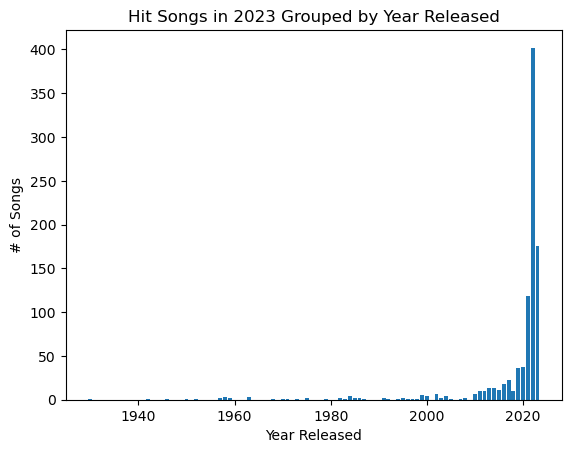

In [8]:
#now that data has been cleaned, want to look at what year it was released
#grabbing frequency of different years
year_frequency = spotify_df['released_year'].value_counts()

#create lists for chart
year_labels = []
frequency_values = []
for x,y in year_frequency.items():
    year_labels.append(x)
    frequency_values.append(y)
#create chart
plt.bar(year_labels, frequency_values)
plt.title('Hit Songs in 2023 Grouped by Year Released')
plt.xlabel("Year Released")
plt.ylabel("# of Songs")
#anticipated most values to be in the 2020-2023 range, but there also
#seems to be a bit of a resurgance in early 80s and late 90s/early 2000s music, 
#which we can investigate further later

## Exploring Models

#### Additional EDA step to break down tracks with multiple artists into individual artists

In [9]:
df_copy = spotify_df.copy()

# identify rows w/ multiple artist
multiple_artists_mask = df_copy['artist(s)_name'].str.contains(', |,')

# duplicate rows w/ multiple artists, split artist names
df_multiple_artists = df_copy[multiple_artists_mask].copy()
df_multiple_artists['artist(s)_name'] = df_multiple_artists['artist(s)_name'].str.split(', ')
df_multiple_artists = df_multiple_artists.explode('artist(s)_name')

# remove original rows w/ multiple artists
df_copy = df_copy[~multiple_artists_mask]

# concatenate duplicated rows
df_copy = pd.concat([df_copy, df_multiple_artists], ignore_index=True)

# reset the index 
df_copy.reset_index(drop=True, inplace=True)

# reassign
spotify_df = df_copy
spotify_df

,track_name,artist(s)_name,artist_count,released_year,released_month,released_day,in_spotify_playlists,in_spotify_charts,streams,in_apple_playlists,in_apple_charts,bpm,key,mode,danceability_%,valence_%,energy_%,acousticness_%,instrumentalness_%,liveness_%,speechiness_%
0,LALA,Myke Towers,1,2023,3,23,1474,48,133716286,48,126,92,C#,Major,71,61,74,7,0,10,4
1,vampire,Olivia Rodrigo,1,2023,6,30,1397,113,140003974,94,207,138,F,Major,51,32,53,17,0,31,6
2,Cruel Summer,Taylor Swift,1,2019,8,23,7858,100,800840817,116,207,170,A,Major,55,58,72,11,0,11,15
3,WHERE SHE GOES,Bad Bunny,1,2023,5,18,3133,50,303236322,84,133,144,A,Minor,65,23,80,14,63,11,6
4,Columbia,Quevedo,1,2023,7,7,714,43,58149378,25,89,100,F,Major,67,26,71,37,0,11,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1476,A Veces (feat. Feid),Feid,2,2022,11,3,573,0,73513683,2,0,92,C#,Major,80,81,67,4,0,8,6
1477,A Veces (feat. Feid),Paulo Londra,2,2022,11,3,573,0,73513683,2,0,92,C#,Major,80,81,67,4,0,8,6
1478,En La De Ella,Feid,3,2022,10,20,1320,0,133895612,29,26,97,C#,Major,82,67,77,8,0,12,5
1479,En La De Ella,Sech,3,2022,10,20,1320,0,133895612,29,26,97,C#,Major,82,67,77,8,0,12,5


#### Top 10 Spotify Artists in 2023

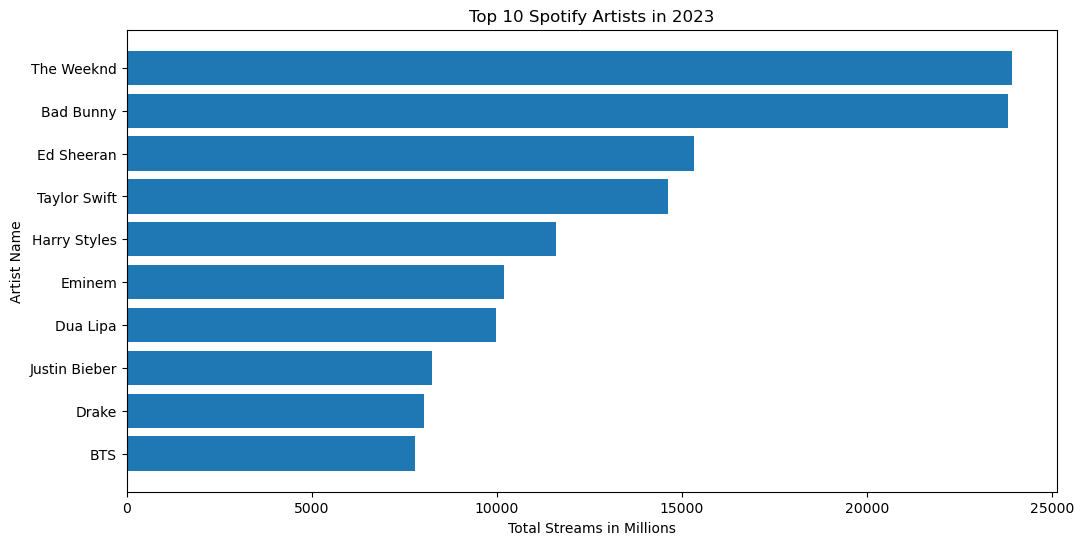

In [10]:
# Visualization 1: Top Artists by Total Streams
top_artists_df = spotify_df.groupby('artist(s)_name')['streams'].sum().reset_index()
top_artists_df = top_artists_df.sort_values(by='streams', ascending=False).head(10)

# Divide the streams by 1 million to make the numbers more readable
div = 1e6
top_artists_df['streams'] = top_artists_df['streams'] / div

# Plot the bar chart
plt.figure(figsize=(12, 6))
plt.barh(top_artists_df['artist(s)_name'], top_artists_df['streams'])
plt.title('Top 10 Spotify Artists in 2023')
plt.xlabel('Total Streams in Millions')
plt.ylabel('Artist Name')
plt.gca().invert_yaxis()
plt.show()

The bar plot displays the most popular music artists in 2023, based on how often their songs were played. The Weeknd is at the top with nearly 24 billion streams.

#### Data partitioning function

In [11]:
def partition_data(X: np.ndarray, y: np.ndarray, seed: int) -> np.ndarray:
    """
    Input numpy arrays for X and y.

    Parameters:
    - X (np.ndarray): a numpy array that contains the explanatory variables
    - y (np.ndarray): a numpy array that contains the target variable
    - seed(integer): the random state for reproducibilty

    Returns:
    - np.ndarray: X_train, X_test, y_train, y_test
    """

    # split the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X,
                                                        y,
                                                        test_size=0.3,
                                                        random_state=seed,
                                                        ) 
    
    return X_train, X_test, y_train, y_test

#### Scale and Encode features 

In [12]:
# get features and target
X = spotify_df[['artist(s)_name', 'artist_count', 'released_year', 'released_month', 'released_day', 'in_spotify_playlists', 
               'in_spotify_charts', 'in_apple_playlists', 'in_apple_charts', 'bpm', 'key', 'mode', 'danceability_%', 
               'valence_%', 'energy_%', 'acousticness_%', 'instrumentalness_%', 'liveness_%', 'speechiness_%']]

y = spotify_df['streams']
          
# partition data
X_train, X_test, y_train, y_test = partition_data(X, y, 7)
X_train = X_train.copy()
X_test  = X_test.copy()

# establish numerical features
numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()

# encode training data
# encode categorical features
encoder = OneHotEncoder(handle_unknown='ignore')
encoded_categorical = encoder.fit_transform(X_train[['artist(s)_name', 'key', 'mode']])

# concatenate encoded categorical features with numeric features
X_train_encoded = pd.concat([pd.DataFrame(encoded_categorical.toarray(), columns=encoder.get_feature_names_out(['artist(s)_name', 'key', 'mode'])),
                             X_train[numeric_features].reset_index(drop=True)], axis=1)

# scale numeric features
scaler = StandardScaler()
X_train_encoded[numeric_features] = scaler.fit_transform(X_train_encoded[numeric_features])

# encode test data
# use same encoder and scaler objects from training
encoded_categorical_test = encoder.transform(X_test[['artist(s)_name', 'key', 'mode']])
X_test_encoded = pd.concat([pd.DataFrame(encoded_categorical_test.toarray(), columns=encoder.get_feature_names_out(['artist(s)_name', 'key', 'mode'])),
                            X_test[numeric_features].reset_index(drop=True)], axis=1)

X_test_encoded[numeric_features] = scaler.transform(X_test_encoded[numeric_features])


#### SVM model

In [13]:
# build
svm = SVR()  
svm.fit(X_train_encoded, y_train)


# establish hyperparameter values
c_values = np.arange(1, 5, 1)
gamma_values = np.arange(0, 5, 1)

# hyperparameter tuning
param_grid_svm = {
    'C': list(c_values),
    'kernel': ['linear', 'rbf'],  
    'gamma': ['scale', 'auto'] + list(gamma_values)
    
}

# create GridSearchCV instance
grid_search_svm = GridSearchCV(svm, param_grid_svm, cv=5, verbose=10)

# fit data to find optimal hyperparameters
grid_search_svm.fit(X_train_encoded, y_train)

# get best model from GridSearchCV
best_svm_model = grid_search_svm.best_estimator_

# predictions from best model
y_pred_best = best_svm_model.predict(X_test_encoded)


Fitting 5 folds for each of 56 candidates, totalling 280 fits
[CV 1/5; 1/56] START C=1, gamma=scale, kernel=linear............................
[CV 1/5; 1/56] END C=1, gamma=scale, kernel=linear;, score=-0.144 total time=   0.3s
[CV 2/5; 1/56] START C=1, gamma=scale, kernel=linear............................
[CV 2/5; 1/56] END C=1, gamma=scale, kernel=linear;, score=-0.142 total time=   0.2s
[CV 3/5; 1/56] START C=1, gamma=scale, kernel=linear............................
[CV 3/5; 1/56] END C=1, gamma=scale, kernel=linear;, score=-0.168 total time=   0.3s
[CV 4/5; 1/56] START C=1, gamma=scale, kernel=linear............................
[CV 4/5; 1/56] END C=1, gamma=scale, kernel=linear;, score=-0.168 total time=   0.2s
[CV 5/5; 1/56] START C=1, gamma=scale, kernel=linear............................
[CV 5/5; 1/56] END C=1, gamma=scale, kernel=linear;, score=-0.146 total time=   0.2s
[CV 1/5; 2/56] START C=1, gamma=scale, kernel=rbf...............................
[CV 1/5; 2/56] END C=1, gam

[CV 1/5; 11/56] END C=1, gamma=3, kernel=linear;, score=-0.144 total time=   0.2s
[CV 2/5; 11/56] START C=1, gamma=3, kernel=linear...............................
[CV 2/5; 11/56] END C=1, gamma=3, kernel=linear;, score=-0.142 total time=   0.2s
[CV 3/5; 11/56] START C=1, gamma=3, kernel=linear...............................
[CV 3/5; 11/56] END C=1, gamma=3, kernel=linear;, score=-0.168 total time=   0.2s
[CV 4/5; 11/56] START C=1, gamma=3, kernel=linear...............................
[CV 4/5; 11/56] END C=1, gamma=3, kernel=linear;, score=-0.168 total time=   0.2s
[CV 5/5; 11/56] START C=1, gamma=3, kernel=linear...............................
[CV 5/5; 11/56] END C=1, gamma=3, kernel=linear;, score=-0.146 total time=   0.2s
[CV 1/5; 12/56] START C=1, gamma=3, kernel=rbf..................................
[CV 1/5; 12/56] END ..C=1, gamma=3, kernel=rbf;, score=-0.144 total time=   0.3s
[CV 2/5; 12/56] START C=1, gamma=3, kernel=rbf..................................
[CV 2/5; 12/56] END ..C

[CV 2/5; 21/56] END C=2, gamma=1, kernel=linear;, score=-0.142 total time=   0.2s
[CV 3/5; 21/56] START C=2, gamma=1, kernel=linear...............................
[CV 3/5; 21/56] END C=2, gamma=1, kernel=linear;, score=-0.168 total time=   0.2s
[CV 4/5; 21/56] START C=2, gamma=1, kernel=linear...............................
[CV 4/5; 21/56] END C=2, gamma=1, kernel=linear;, score=-0.168 total time=   0.2s
[CV 5/5; 21/56] START C=2, gamma=1, kernel=linear...............................
[CV 5/5; 21/56] END C=2, gamma=1, kernel=linear;, score=-0.146 total time=   0.2s
[CV 1/5; 22/56] START C=2, gamma=1, kernel=rbf..................................
[CV 1/5; 22/56] END ..C=2, gamma=1, kernel=rbf;, score=-0.144 total time=   0.3s
[CV 2/5; 22/56] START C=2, gamma=1, kernel=rbf..................................
[CV 2/5; 22/56] END ..C=2, gamma=1, kernel=rbf;, score=-0.142 total time=   0.3s
[CV 3/5; 22/56] START C=2, gamma=1, kernel=rbf..................................
[CV 3/5; 22/56] END ..C=

[CV 3/5; 31/56] END C=3, gamma=auto, kernel=linear;, score=-0.168 total time=   0.2s
[CV 4/5; 31/56] START C=3, gamma=auto, kernel=linear............................
[CV 4/5; 31/56] END C=3, gamma=auto, kernel=linear;, score=-0.168 total time=   0.2s
[CV 5/5; 31/56] START C=3, gamma=auto, kernel=linear............................
[CV 5/5; 31/56] END C=3, gamma=auto, kernel=linear;, score=-0.146 total time=   0.2s
[CV 1/5; 32/56] START C=3, gamma=auto, kernel=rbf...............................
[CV 1/5; 32/56] END C=3, gamma=auto, kernel=rbf;, score=-0.144 total time=   0.3s
[CV 2/5; 32/56] START C=3, gamma=auto, kernel=rbf...............................
[CV 2/5; 32/56] END C=3, gamma=auto, kernel=rbf;, score=-0.142 total time=   0.3s
[CV 3/5; 32/56] START C=3, gamma=auto, kernel=rbf...............................
[CV 3/5; 32/56] END C=3, gamma=auto, kernel=rbf;, score=-0.168 total time=   0.3s
[CV 4/5; 32/56] START C=3, gamma=auto, kernel=rbf...............................
[CV 4/5; 32/5

[CV 4/5; 41/56] END C=3, gamma=4, kernel=linear;, score=-0.168 total time=   0.2s
[CV 5/5; 41/56] START C=3, gamma=4, kernel=linear...............................
[CV 5/5; 41/56] END C=3, gamma=4, kernel=linear;, score=-0.146 total time=   0.2s
[CV 1/5; 42/56] START C=3, gamma=4, kernel=rbf..................................
[CV 1/5; 42/56] END ..C=3, gamma=4, kernel=rbf;, score=-0.144 total time=   0.3s
[CV 2/5; 42/56] START C=3, gamma=4, kernel=rbf..................................
[CV 2/5; 42/56] END ..C=3, gamma=4, kernel=rbf;, score=-0.142 total time=   0.3s
[CV 3/5; 42/56] START C=3, gamma=4, kernel=rbf..................................
[CV 3/5; 42/56] END ..C=3, gamma=4, kernel=rbf;, score=-0.168 total time=   0.3s
[CV 4/5; 42/56] START C=3, gamma=4, kernel=rbf..................................
[CV 4/5; 42/56] END ..C=3, gamma=4, kernel=rbf;, score=-0.168 total time=   0.3s
[CV 5/5; 42/56] START C=3, gamma=4, kernel=rbf..................................
[CV 5/5; 42/56] END ..C=3,

[CV 5/5; 51/56] END C=4, gamma=2, kernel=linear;, score=-0.146 total time=   0.2s
[CV 1/5; 52/56] START C=4, gamma=2, kernel=rbf..................................
[CV 1/5; 52/56] END ..C=4, gamma=2, kernel=rbf;, score=-0.144 total time=   0.3s
[CV 2/5; 52/56] START C=4, gamma=2, kernel=rbf..................................
[CV 2/5; 52/56] END ..C=4, gamma=2, kernel=rbf;, score=-0.142 total time=   0.3s
[CV 3/5; 52/56] START C=4, gamma=2, kernel=rbf..................................
[CV 3/5; 52/56] END ..C=4, gamma=2, kernel=rbf;, score=-0.168 total time=   0.3s
[CV 4/5; 52/56] START C=4, gamma=2, kernel=rbf..................................
[CV 4/5; 52/56] END ..C=4, gamma=2, kernel=rbf;, score=-0.168 total time=   0.3s
[CV 5/5; 52/56] START C=4, gamma=2, kernel=rbf..................................
[CV 5/5; 52/56] END ..C=4, gamma=2, kernel=rbf;, score=-0.146 total time=   0.3s
[CV 1/5; 53/56] START C=4, gamma=3, kernel=linear...............................
[CV 1/5; 53/56] END C=4, ga

In [14]:
# display best model results
print("Best Model Parameters: ", grid_search_svm.best_params_)
print(" Score: ", grid_search_svm.best_score_)


Best Model Parameters:  {'C': 4, 'gamma': 'scale', 'kernel': 'linear'}
 Score:  -0.15343828526423414


#### kNN model

In [15]:
# convert to arrays for kNN model
X_train_encoded_knn = X_train_encoded.values
X_test_encoded_knn = X_test_encoded.values

# build model
knn = KNeighborsRegressor()
knn.fit(X_train_encoded_knn, y_train)

# hyperparameter tuning
param_grid_knn = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}


# create GridSearchCV instance
grid_search_knn = GridSearchCV(knn, param_grid_knn, cv=5, verbose=10)

# fit data to find optimal hyperparameters
grid_search_knn.fit(X_train_encoded_knn, y_train)

# get best model from GridSearchCV
best_knn_model = grid_search_knn.best_estimator_

# predictions from best model
y_pred_best = best_knn_model.predict(X_test_encoded_knn)


Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV 1/5; 1/24] START metric=euclidean, n_neighbors=3, weights=uniform...........
[CV 1/5; 1/24] END metric=euclidean, n_neighbors=3, weights=uniform;, score=0.631 total time=   0.2s
[CV 2/5; 1/24] START metric=euclidean, n_neighbors=3, weights=uniform...........
[CV 2/5; 1/24] END metric=euclidean, n_neighbors=3, weights=uniform;, score=0.695 total time=   0.0s
[CV 3/5; 1/24] START metric=euclidean, n_neighbors=3, weights=uniform...........
[CV 3/5; 1/24] END metric=euclidean, n_neighbors=3, weights=uniform;, score=0.633 total time=   0.0s
[CV 4/5; 1/24] START metric=euclidean, n_neighbors=3, weights=uniform...........
[CV 4/5; 1/24] END metric=euclidean, n_neighbors=3, weights=uniform;, score=0.620 total time=   0.1s
[CV 5/5; 1/24] START metric=euclidean, n_neighbors=3, weights=uniform...........
[CV 5/5; 1/24] END metric=euclidean, n_neighbors=3, weights=uniform;, score=0.710 total time=   0.0s
[CV 1/5; 2/24] START metric=

[CV 4/5; 10/24] END metric=manhattan, n_neighbors=3, weights=distance;, score=0.648 total time=   0.0s
[CV 5/5; 10/24] START metric=manhattan, n_neighbors=3, weights=distance.........
[CV 5/5; 10/24] END metric=manhattan, n_neighbors=3, weights=distance;, score=0.785 total time=   0.0s
[CV 1/5; 11/24] START metric=manhattan, n_neighbors=5, weights=uniform..........
[CV 1/5; 11/24] END metric=manhattan, n_neighbors=5, weights=uniform;, score=0.675 total time=   0.0s
[CV 2/5; 11/24] START metric=manhattan, n_neighbors=5, weights=uniform..........
[CV 2/5; 11/24] END metric=manhattan, n_neighbors=5, weights=uniform;, score=0.677 total time=   0.0s
[CV 3/5; 11/24] START metric=manhattan, n_neighbors=5, weights=uniform..........
[CV 3/5; 11/24] END metric=manhattan, n_neighbors=5, weights=uniform;, score=0.624 total time=   0.0s
[CV 4/5; 11/24] START metric=manhattan, n_neighbors=5, weights=uniform..........
[CV 4/5; 11/24] END metric=manhattan, n_neighbors=5, weights=uniform;, score=0.623 

[CV 5/5; 20/24] END metric=minkowski, n_neighbors=5, weights=distance;, score=0.737 total time=   0.0s
[CV 1/5; 21/24] START metric=minkowski, n_neighbors=7, weights=uniform..........
[CV 1/5; 21/24] END metric=minkowski, n_neighbors=7, weights=uniform;, score=0.647 total time=   0.0s
[CV 2/5; 21/24] START metric=minkowski, n_neighbors=7, weights=uniform..........
[CV 2/5; 21/24] END metric=minkowski, n_neighbors=7, weights=uniform;, score=0.691 total time=   0.0s
[CV 3/5; 21/24] START metric=minkowski, n_neighbors=7, weights=uniform..........
[CV 3/5; 21/24] END metric=minkowski, n_neighbors=7, weights=uniform;, score=0.631 total time=   0.0s
[CV 4/5; 21/24] START metric=minkowski, n_neighbors=7, weights=uniform..........
[CV 4/5; 21/24] END metric=minkowski, n_neighbors=7, weights=uniform;, score=0.617 total time=   0.0s
[CV 5/5; 21/24] START metric=minkowski, n_neighbors=7, weights=uniform..........
[CV 5/5; 21/24] END metric=minkowski, n_neighbors=7, weights=uniform;, score=0.686 t

In [16]:
# display best model results
print("Best Model Parameters: ", grid_search_knn.best_params_)
print(" Score: ", grid_search_knn.best_score_)


Best Model Parameters:  {'metric': 'manhattan', 'n_neighbors': 5, 'weights': 'distance'}
 Score:  0.7216346418202106


#### Random Forest Regressor

In [17]:
# build model
rf = RandomForestRegressor(random_state=42)
rf.fit(X_train_encoded, y_train)

# hyperparameter tuning
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# create GridSearchCV instance
grid_search_rf = GridSearchCV(rf, param_grid_rf, cv=5, verbose=10)

# fit data to find optimal hyperparameters
grid_search_rf.fit(X_train_encoded, y_train)

# get best model from GridSearchCV
best_rf_model = grid_search_rf.best_estimator_

# predictions from best model
y_pred_best = best_rf_model.predict(X_test_encoded)



Fitting 5 folds for each of 108 candidates, totalling 540 fits
[CV 1/5; 1/108] START max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50
[CV 1/5; 1/108] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50;, score=0.876 total time=   0.4s
[CV 2/5; 1/108] START max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50
[CV 2/5; 1/108] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50;, score=0.863 total time=   0.4s
[CV 3/5; 1/108] START max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50
[CV 3/5; 1/108] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50;, score=0.823 total time=   0.4s
[CV 4/5; 1/108] START max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50
[CV 4/5; 1/108] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50;, score=0.827 total time=   0.4s
[CV 5/5; 1/108] START max_depth=None, min_samples_lea

[CV 3/5; 8/108] END max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.819 total time=   0.6s
[CV 4/5; 8/108] START max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=100
[CV 4/5; 8/108] END max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.818 total time=   0.6s
[CV 5/5; 8/108] START max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=100
[CV 5/5; 8/108] END max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.831 total time=   0.5s
[CV 1/5; 9/108] START max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=200
[CV 1/5; 9/108] END max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=200;, score=0.871 total time=   1.1s
[CV 2/5; 9/108] START max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=200
[CV 2/5; 9/108] END max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=200;, sco

[CV 5/5; 15/108] END max_depth=None, min_samples_leaf=2, min_samples_split=5, n_estimators=200;, score=0.859 total time=   1.1s
[CV 1/5; 16/108] START max_depth=None, min_samples_leaf=2, min_samples_split=10, n_estimators=50
[CV 1/5; 16/108] END max_depth=None, min_samples_leaf=2, min_samples_split=10, n_estimators=50;, score=0.859 total time=   0.2s
[CV 2/5; 16/108] START max_depth=None, min_samples_leaf=2, min_samples_split=10, n_estimators=50
[CV 2/5; 16/108] END max_depth=None, min_samples_leaf=2, min_samples_split=10, n_estimators=50;, score=0.863 total time=   0.2s
[CV 3/5; 16/108] START max_depth=None, min_samples_leaf=2, min_samples_split=10, n_estimators=50
[CV 3/5; 16/108] END max_depth=None, min_samples_leaf=2, min_samples_split=10, n_estimators=50;, score=0.826 total time=   0.2s
[CV 4/5; 16/108] START max_depth=None, min_samples_leaf=2, min_samples_split=10, n_estimators=50
[CV 4/5; 16/108] END max_depth=None, min_samples_leaf=2, min_samples_split=10, n_estimators=50;, sco

[CV 2/5; 23/108] END max_depth=None, min_samples_leaf=4, min_samples_split=5, n_estimators=100;, score=0.858 total time=   0.5s
[CV 3/5; 23/108] START max_depth=None, min_samples_leaf=4, min_samples_split=5, n_estimators=100
[CV 3/5; 23/108] END max_depth=None, min_samples_leaf=4, min_samples_split=5, n_estimators=100;, score=0.827 total time=   0.5s
[CV 4/5; 23/108] START max_depth=None, min_samples_leaf=4, min_samples_split=5, n_estimators=100
[CV 4/5; 23/108] END max_depth=None, min_samples_leaf=4, min_samples_split=5, n_estimators=100;, score=0.826 total time=   0.5s
[CV 5/5; 23/108] START max_depth=None, min_samples_leaf=4, min_samples_split=5, n_estimators=100
[CV 5/5; 23/108] END max_depth=None, min_samples_leaf=4, min_samples_split=5, n_estimators=100;, score=0.844 total time=   0.5s
[CV 1/5; 24/108] START max_depth=None, min_samples_leaf=4, min_samples_split=5, n_estimators=200
[CV 1/5; 24/108] END max_depth=None, min_samples_leaf=4, min_samples_split=5, n_estimators=200;, sco

[CV 4/5; 30/108] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=200;, score=0.819 total time=   1.9s
[CV 5/5; 30/108] START max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=200
[CV 5/5; 30/108] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=200;, score=0.841 total time=   1.1s
[CV 1/5; 31/108] START max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=50
[CV 1/5; 31/108] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=50;, score=0.873 total time=   0.3s
[CV 2/5; 31/108] START max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=50
[CV 2/5; 31/108] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=50;, score=0.861 total time=   0.3s
[CV 3/5; 31/108] START max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=50
[CV 3/5; 31/108] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=50;, score=0.814 total time=   0

[CV 2/5; 38/108] END max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=100;, score=0.864 total time=   0.5s
[CV 3/5; 38/108] START max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=100
[CV 3/5; 38/108] END max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=100;, score=0.839 total time=   0.5s
[CV 4/5; 38/108] START max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=100
[CV 4/5; 38/108] END max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=100;, score=0.822 total time=   0.5s
[CV 5/5; 38/108] START max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=100
[CV 5/5; 38/108] END max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=100;, score=0.859 total time=   0.5s
[CV 1/5; 39/108] START max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=200
[CV 1/5; 39/108] END max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=200;, score=0.865 total tim

[CV 5/5; 45/108] END max_depth=10, min_samples_leaf=2, min_samples_split=10, n_estimators=200;, score=0.850 total time=   0.9s
[CV 1/5; 46/108] START max_depth=10, min_samples_leaf=4, min_samples_split=2, n_estimators=50
[CV 1/5; 46/108] END max_depth=10, min_samples_leaf=4, min_samples_split=2, n_estimators=50;, score=0.866 total time=   0.2s
[CV 2/5; 46/108] START max_depth=10, min_samples_leaf=4, min_samples_split=2, n_estimators=50
[CV 2/5; 46/108] END max_depth=10, min_samples_leaf=4, min_samples_split=2, n_estimators=50;, score=0.860 total time=   0.2s
[CV 3/5; 46/108] START max_depth=10, min_samples_leaf=4, min_samples_split=2, n_estimators=50
[CV 3/5; 46/108] END max_depth=10, min_samples_leaf=4, min_samples_split=2, n_estimators=50;, score=0.824 total time=   0.2s
[CV 4/5; 46/108] START max_depth=10, min_samples_leaf=4, min_samples_split=2, n_estimators=50
[CV 4/5; 46/108] END max_depth=10, min_samples_leaf=4, min_samples_split=2, n_estimators=50;, score=0.824 total time=   0.

[CV 3/5; 53/108] END max_depth=10, min_samples_leaf=4, min_samples_split=10, n_estimators=100;, score=0.823 total time=   0.4s
[CV 4/5; 53/108] START max_depth=10, min_samples_leaf=4, min_samples_split=10, n_estimators=100
[CV 4/5; 53/108] END max_depth=10, min_samples_leaf=4, min_samples_split=10, n_estimators=100;, score=0.822 total time=   0.4s
[CV 5/5; 53/108] START max_depth=10, min_samples_leaf=4, min_samples_split=10, n_estimators=100
[CV 5/5; 53/108] END max_depth=10, min_samples_leaf=4, min_samples_split=10, n_estimators=100;, score=0.842 total time=   0.4s
[CV 1/5; 54/108] START max_depth=10, min_samples_leaf=4, min_samples_split=10, n_estimators=200
[CV 1/5; 54/108] END max_depth=10, min_samples_leaf=4, min_samples_split=10, n_estimators=200;, score=0.866 total time=   0.9s
[CV 2/5; 54/108] START max_depth=10, min_samples_leaf=4, min_samples_split=10, n_estimators=200
[CV 2/5; 54/108] END max_depth=10, min_samples_leaf=4, min_samples_split=10, n_estimators=200;, score=0.851 

[CV 1/5; 61/108] END max_depth=20, min_samples_leaf=1, min_samples_split=10, n_estimators=50;, score=0.867 total time=   0.3s
[CV 2/5; 61/108] START max_depth=20, min_samples_leaf=1, min_samples_split=10, n_estimators=50
[CV 2/5; 61/108] END max_depth=20, min_samples_leaf=1, min_samples_split=10, n_estimators=50;, score=0.860 total time=   0.3s
[CV 3/5; 61/108] START max_depth=20, min_samples_leaf=1, min_samples_split=10, n_estimators=50
[CV 3/5; 61/108] END max_depth=20, min_samples_leaf=1, min_samples_split=10, n_estimators=50;, score=0.813 total time=   0.3s
[CV 4/5; 61/108] START max_depth=20, min_samples_leaf=1, min_samples_split=10, n_estimators=50
[CV 4/5; 61/108] END max_depth=20, min_samples_leaf=1, min_samples_split=10, n_estimators=50;, score=0.818 total time=   0.3s
[CV 5/5; 61/108] START max_depth=20, min_samples_leaf=1, min_samples_split=10, n_estimators=50
[CV 5/5; 61/108] END max_depth=20, min_samples_leaf=1, min_samples_split=10, n_estimators=50;, score=0.828 total tim

[CV 4/5; 68/108] END max_depth=20, min_samples_leaf=2, min_samples_split=5, n_estimators=100;, score=0.824 total time=   0.6s
[CV 5/5; 68/108] START max_depth=20, min_samples_leaf=2, min_samples_split=5, n_estimators=100
[CV 5/5; 68/108] END max_depth=20, min_samples_leaf=2, min_samples_split=5, n_estimators=100;, score=0.858 total time=   0.5s
[CV 1/5; 69/108] START max_depth=20, min_samples_leaf=2, min_samples_split=5, n_estimators=200
[CV 1/5; 69/108] END max_depth=20, min_samples_leaf=2, min_samples_split=5, n_estimators=200;, score=0.865 total time=   1.2s
[CV 2/5; 69/108] START max_depth=20, min_samples_leaf=2, min_samples_split=5, n_estimators=200
[CV 2/5; 69/108] END max_depth=20, min_samples_leaf=2, min_samples_split=5, n_estimators=200;, score=0.859 total time=   1.1s
[CV 3/5; 69/108] START max_depth=20, min_samples_leaf=2, min_samples_split=5, n_estimators=200
[CV 3/5; 69/108] END max_depth=20, min_samples_leaf=2, min_samples_split=5, n_estimators=200;, score=0.837 total tim

[CV 2/5; 76/108] END max_depth=20, min_samples_leaf=4, min_samples_split=5, n_estimators=50;, score=0.860 total time=   0.2s
[CV 3/5; 76/108] START max_depth=20, min_samples_leaf=4, min_samples_split=5, n_estimators=50
[CV 3/5; 76/108] END max_depth=20, min_samples_leaf=4, min_samples_split=5, n_estimators=50;, score=0.825 total time=   0.2s
[CV 4/5; 76/108] START max_depth=20, min_samples_leaf=4, min_samples_split=5, n_estimators=50
[CV 4/5; 76/108] END max_depth=20, min_samples_leaf=4, min_samples_split=5, n_estimators=50;, score=0.825 total time=   0.2s
[CV 5/5; 76/108] START max_depth=20, min_samples_leaf=4, min_samples_split=5, n_estimators=50
[CV 5/5; 76/108] END max_depth=20, min_samples_leaf=4, min_samples_split=5, n_estimators=50;, score=0.841 total time=   0.2s
[CV 1/5; 77/108] START max_depth=20, min_samples_leaf=4, min_samples_split=5, n_estimators=100
[CV 1/5; 77/108] END max_depth=20, min_samples_leaf=4, min_samples_split=5, n_estimators=100;, score=0.865 total time=   0.

[CV 5/5; 83/108] END max_depth=30, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=0.843 total time=   0.7s
[CV 1/5; 84/108] START max_depth=30, min_samples_leaf=1, min_samples_split=2, n_estimators=200
[CV 1/5; 84/108] END max_depth=30, min_samples_leaf=1, min_samples_split=2, n_estimators=200;, score=0.878 total time=   1.5s
[CV 2/5; 84/108] START max_depth=30, min_samples_leaf=1, min_samples_split=2, n_estimators=200
[CV 2/5; 84/108] END max_depth=30, min_samples_leaf=1, min_samples_split=2, n_estimators=200;, score=0.859 total time=   1.5s
[CV 3/5; 84/108] START max_depth=30, min_samples_leaf=1, min_samples_split=2, n_estimators=200
[CV 3/5; 84/108] END max_depth=30, min_samples_leaf=1, min_samples_split=2, n_estimators=200;, score=0.830 total time=   1.5s
[CV 4/5; 84/108] START max_depth=30, min_samples_leaf=1, min_samples_split=2, n_estimators=200
[CV 4/5; 84/108] END max_depth=30, min_samples_leaf=1, min_samples_split=2, n_estimators=200;, score=0.827 total tim

[CV 3/5; 91/108] END max_depth=30, min_samples_leaf=2, min_samples_split=2, n_estimators=50;, score=0.830 total time=   0.3s
[CV 4/5; 91/108] START max_depth=30, min_samples_leaf=2, min_samples_split=2, n_estimators=50
[CV 4/5; 91/108] END max_depth=30, min_samples_leaf=2, min_samples_split=2, n_estimators=50;, score=0.827 total time=   0.3s
[CV 5/5; 91/108] START max_depth=30, min_samples_leaf=2, min_samples_split=2, n_estimators=50
[CV 5/5; 91/108] END max_depth=30, min_samples_leaf=2, min_samples_split=2, n_estimators=50;, score=0.850 total time=   0.3s
[CV 1/5; 92/108] START max_depth=30, min_samples_leaf=2, min_samples_split=2, n_estimators=100
[CV 1/5; 92/108] END max_depth=30, min_samples_leaf=2, min_samples_split=2, n_estimators=100;, score=0.865 total time=   0.6s
[CV 2/5; 92/108] START max_depth=30, min_samples_leaf=2, min_samples_split=2, n_estimators=100
[CV 2/5; 92/108] END max_depth=30, min_samples_leaf=2, min_samples_split=2, n_estimators=100;, score=0.866 total time=   

[CV 1/5; 99/108] END max_depth=30, min_samples_leaf=2, min_samples_split=10, n_estimators=200;, score=0.860 total time=   1.0s
[CV 2/5; 99/108] START max_depth=30, min_samples_leaf=2, min_samples_split=10, n_estimators=200
[CV 2/5; 99/108] END max_depth=30, min_samples_leaf=2, min_samples_split=10, n_estimators=200;, score=0.856 total time=   1.0s
[CV 3/5; 99/108] START max_depth=30, min_samples_leaf=2, min_samples_split=10, n_estimators=200
[CV 3/5; 99/108] END max_depth=30, min_samples_leaf=2, min_samples_split=10, n_estimators=200;, score=0.826 total time=   1.0s
[CV 4/5; 99/108] START max_depth=30, min_samples_leaf=2, min_samples_split=10, n_estimators=200
[CV 4/5; 99/108] END max_depth=30, min_samples_leaf=2, min_samples_split=10, n_estimators=200;, score=0.818 total time=   1.0s
[CV 5/5; 99/108] START max_depth=30, min_samples_leaf=2, min_samples_split=10, n_estimators=200
[CV 5/5; 99/108] END max_depth=30, min_samples_leaf=2, min_samples_split=10, n_estimators=200;, score=0.851 

[CV 3/5; 106/108] END max_depth=30, min_samples_leaf=4, min_samples_split=10, n_estimators=50;, score=0.823 total time=   0.2s
[CV 4/5; 106/108] START max_depth=30, min_samples_leaf=4, min_samples_split=10, n_estimators=50
[CV 4/5; 106/108] END max_depth=30, min_samples_leaf=4, min_samples_split=10, n_estimators=50;, score=0.821 total time=   0.2s
[CV 5/5; 106/108] START max_depth=30, min_samples_leaf=4, min_samples_split=10, n_estimators=50
[CV 5/5; 106/108] END max_depth=30, min_samples_leaf=4, min_samples_split=10, n_estimators=50;, score=0.837 total time=   0.2s
[CV 1/5; 107/108] START max_depth=30, min_samples_leaf=4, min_samples_split=10, n_estimators=100
[CV 1/5; 107/108] END max_depth=30, min_samples_leaf=4, min_samples_split=10, n_estimators=100;, score=0.865 total time=   0.4s
[CV 2/5; 107/108] START max_depth=30, min_samples_leaf=4, min_samples_split=10, n_estimators=100
[CV 2/5; 107/108] END max_depth=30, min_samples_leaf=4, min_samples_split=10, n_estimators=100;, score=0.

In [18]:
# display best model results
print("Best Model Parameters: ", grid_search_rf.best_params_)
print(" Score: ", grid_search_rf.best_score_)


Best Model Parameters:  {'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
 Score:  0.850763286230903


## Final Model Choice & Tuning

Based on our preliminary modeling efforts, we can see that our **Random Forest Regressor** is the best model for our data. We will now further tune this model for optimization. To do this, we will adjust our initially tested hyperparameters around the optimal values from our grid search, and we will also test a few additional paramters.

In [19]:
# build model
rf_2 = RandomForestRegressor(random_state=42)
rf_2.fit(X_train_encoded, y_train)

# hyperparameter tuning
param_grid_rf_2 = {
    'n_estimators': [80, 100, 120, 150], 
    'max_depth': [15, 20, 25], 
    'min_samples_split': [2, 3, 4], 
    'min_samples_leaf': [1, 2, 3],  
    'max_features': ['auto', 'sqrt', 'log2', None],  
    'bootstrap': [True, False]  
}


# create GridSearchCV instance
grid_search_rf_2 = GridSearchCV(rf_2, param_grid_rf_2, cv=5, verbose=10)

# fit data to find optimal hyperparameters
grid_search_rf_2.fit(X_train_encoded, y_train)

# get best model from GridSearchCV
best_rf_2_model = grid_search_rf_2.best_estimator_

# predictions from best model
y_pred_best = best_rf_2_model.predict(X_test_encoded)



Fitting 5 folds for each of 864 candidates, totalling 4320 fits
[CV 1/5; 1/864] START bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=80
[CV 1/5; 1/864] END bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=80;, score=nan total time=   0.0s
[CV 2/5; 1/864] START bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=80
[CV 2/5; 1/864] END bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=80;, score=nan total time=   0.0s
[CV 3/5; 1/864] START bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=80
[CV 3/5; 1/864] END bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=80;, score=nan total time=   0.0s
[CV 4/5; 1/864] START bootstrap=True, max_depth=15, max_features=auto, min_sample

[CV 3/5; 33/864] END bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=3, min_samples_split=4, n_estimators=80;, score=nan total time=   0.0s
[CV 4/5; 33/864] START bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=3, min_samples_split=4, n_estimators=80
[CV 4/5; 33/864] END bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=3, min_samples_split=4, n_estimators=80;, score=nan total time=   0.0s
[CV 5/5; 33/864] START bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=3, min_samples_split=4, n_estimators=80
[CV 5/5; 33/864] END bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=3, min_samples_split=4, n_estimators=80;, score=nan total time=   0.0s
[CV 1/5; 34/864] START bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=3, min_samples_split=4, n_estimators=100
[CV 1/5; 34/864] END bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=3, min_samples_split=4, n_estimators=100;, score=na

[CV 2/5; 39/864] END bootstrap=True, max_depth=15, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=120;, score=0.662 total time=   0.1s
[CV 3/5; 39/864] START bootstrap=True, max_depth=15, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=120
[CV 3/5; 39/864] END bootstrap=True, max_depth=15, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=120;, score=0.723 total time=   0.1s
[CV 4/5; 39/864] START bootstrap=True, max_depth=15, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=120
[CV 4/5; 39/864] END bootstrap=True, max_depth=15, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=120;, score=0.703 total time=   0.1s
[CV 5/5; 39/864] START bootstrap=True, max_depth=15, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=120
[CV 5/5; 39/864] END bootstrap=True, max_depth=15, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=120

[CV 2/5; 45/864] END bootstrap=True, max_depth=15, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=80;, score=0.672 total time=   0.1s
[CV 3/5; 45/864] START bootstrap=True, max_depth=15, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=80
[CV 3/5; 45/864] END bootstrap=True, max_depth=15, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=80;, score=0.716 total time=   0.1s
[CV 4/5; 45/864] START bootstrap=True, max_depth=15, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=80
[CV 4/5; 45/864] END bootstrap=True, max_depth=15, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=80;, score=0.704 total time=   0.1s
[CV 5/5; 45/864] START bootstrap=True, max_depth=15, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=80
[CV 5/5; 45/864] END bootstrap=True, max_depth=15, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=80;, scor

[CV 1/5; 51/864] END bootstrap=True, max_depth=15, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=120;, score=0.567 total time=   0.1s
[CV 2/5; 51/864] START bootstrap=True, max_depth=15, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=120
[CV 2/5; 51/864] END bootstrap=True, max_depth=15, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=120;, score=0.524 total time=   0.1s
[CV 3/5; 51/864] START bootstrap=True, max_depth=15, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=120
[CV 3/5; 51/864] END bootstrap=True, max_depth=15, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=120;, score=0.601 total time=   0.1s
[CV 4/5; 51/864] START bootstrap=True, max_depth=15, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=120
[CV 4/5; 51/864] END bootstrap=True, max_depth=15, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=120

[CV 5/5; 56/864] END bootstrap=True, max_depth=15, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=150;, score=0.545 total time=   0.1s
[CV 1/5; 57/864] START bootstrap=True, max_depth=15, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=80
[CV 1/5; 57/864] END bootstrap=True, max_depth=15, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=80;, score=0.555 total time=   0.1s
[CV 2/5; 57/864] START bootstrap=True, max_depth=15, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=80
[CV 2/5; 57/864] END bootstrap=True, max_depth=15, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=80;, score=0.510 total time=   0.1s
[CV 3/5; 57/864] START bootstrap=True, max_depth=15, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=80
[CV 3/5; 57/864] END bootstrap=True, max_depth=15, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=80;, sco

[CV 4/5; 62/864] END bootstrap=True, max_depth=15, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=100;, score=0.427 total time=   0.1s
[CV 5/5; 62/864] START bootstrap=True, max_depth=15, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=100
[CV 5/5; 62/864] END bootstrap=True, max_depth=15, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=100;, score=0.458 total time=   0.1s
[CV 1/5; 63/864] START bootstrap=True, max_depth=15, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=120
[CV 1/5; 63/864] END bootstrap=True, max_depth=15, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=120;, score=0.451 total time=   0.1s
[CV 2/5; 63/864] START bootstrap=True, max_depth=15, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=120
[CV 2/5; 63/864] END bootstrap=True, max_depth=15, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=120

[CV 3/5; 68/864] END bootstrap=True, max_depth=15, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=150;, score=0.461 total time=   0.1s
[CV 4/5; 68/864] START bootstrap=True, max_depth=15, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=150
[CV 4/5; 68/864] END bootstrap=True, max_depth=15, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=150;, score=0.437 total time=   0.1s
[CV 5/5; 68/864] START bootstrap=True, max_depth=15, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=150
[CV 5/5; 68/864] END bootstrap=True, max_depth=15, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=150;, score=0.456 total time=   0.1s
[CV 1/5; 69/864] START bootstrap=True, max_depth=15, max_features=sqrt, min_samples_leaf=3, min_samples_split=4, n_estimators=80
[CV 1/5; 69/864] END bootstrap=True, max_depth=15, max_features=sqrt, min_samples_leaf=3, min_samples_split=4, n_estimators=80;,

[CV 3/5; 74/864] END bootstrap=True, max_depth=15, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=0.536 total time=   0.1s
[CV 4/5; 74/864] START bootstrap=True, max_depth=15, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=100
[CV 4/5; 74/864] END bootstrap=True, max_depth=15, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=0.506 total time=   0.1s
[CV 5/5; 74/864] START bootstrap=True, max_depth=15, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=100
[CV 5/5; 74/864] END bootstrap=True, max_depth=15, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=0.593 total time=   0.1s
[CV 1/5; 75/864] START bootstrap=True, max_depth=15, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=120
[CV 1/5; 75/864] END bootstrap=True, max_depth=15, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=120

[CV 4/5; 80/864] END bootstrap=True, max_depth=15, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=150;, score=0.507 total time=   0.1s
[CV 5/5; 80/864] START bootstrap=True, max_depth=15, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=150
[CV 5/5; 80/864] END bootstrap=True, max_depth=15, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=150;, score=0.556 total time=   0.1s
[CV 1/5; 81/864] START bootstrap=True, max_depth=15, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=80
[CV 1/5; 81/864] END bootstrap=True, max_depth=15, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=80;, score=0.524 total time=   0.0s
[CV 2/5; 81/864] START bootstrap=True, max_depth=15, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=80
[CV 2/5; 81/864] END bootstrap=True, max_depth=15, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=80;, s

[CV 1/5; 87/864] END bootstrap=True, max_depth=15, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=120;, score=0.212 total time=   0.1s
[CV 2/5; 87/864] START bootstrap=True, max_depth=15, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=120
[CV 2/5; 87/864] END bootstrap=True, max_depth=15, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=120;, score=0.169 total time=   0.1s
[CV 3/5; 87/864] START bootstrap=True, max_depth=15, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=120
[CV 3/5; 87/864] END bootstrap=True, max_depth=15, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=120;, score=0.214 total time=   0.1s
[CV 4/5; 87/864] START bootstrap=True, max_depth=15, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=120
[CV 4/5; 87/864] END bootstrap=True, max_depth=15, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=120

[CV 5/5; 93/864] END bootstrap=True, max_depth=15, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=80;, score=0.219 total time=   0.0s
[CV 1/5; 94/864] START bootstrap=True, max_depth=15, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=100
[CV 1/5; 94/864] END bootstrap=True, max_depth=15, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=100;, score=0.211 total time=   0.0s
[CV 2/5; 94/864] START bootstrap=True, max_depth=15, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=100
[CV 2/5; 94/864] END bootstrap=True, max_depth=15, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=100;, score=0.175 total time=   0.0s
[CV 3/5; 94/864] START bootstrap=True, max_depth=15, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=100
[CV 3/5; 94/864] END bootstrap=True, max_depth=15, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=100;

[CV 1/5; 100/864] END bootstrap=True, max_depth=15, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=150;, score=0.150 total time=   0.1s
[CV 2/5; 100/864] START bootstrap=True, max_depth=15, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=150
[CV 2/5; 100/864] END bootstrap=True, max_depth=15, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=150;, score=0.110 total time=   0.1s
[CV 3/5; 100/864] START bootstrap=True, max_depth=15, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=150
[CV 3/5; 100/864] END bootstrap=True, max_depth=15, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=150;, score=0.146 total time=   0.1s
[CV 4/5; 100/864] START bootstrap=True, max_depth=15, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=150
[CV 4/5; 100/864] END bootstrap=True, max_depth=15, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimat

[CV 2/5; 106/864] END bootstrap=True, max_depth=15, max_features=log2, min_samples_leaf=3, min_samples_split=4, n_estimators=100;, score=0.134 total time=   0.0s
[CV 3/5; 106/864] START bootstrap=True, max_depth=15, max_features=log2, min_samples_leaf=3, min_samples_split=4, n_estimators=100
[CV 3/5; 106/864] END bootstrap=True, max_depth=15, max_features=log2, min_samples_leaf=3, min_samples_split=4, n_estimators=100;, score=0.153 total time=   0.0s
[CV 4/5; 106/864] START bootstrap=True, max_depth=15, max_features=log2, min_samples_leaf=3, min_samples_split=4, n_estimators=100
[CV 4/5; 106/864] END bootstrap=True, max_depth=15, max_features=log2, min_samples_leaf=3, min_samples_split=4, n_estimators=100;, score=0.134 total time=   0.0s
[CV 5/5; 106/864] START bootstrap=True, max_depth=15, max_features=log2, min_samples_leaf=3, min_samples_split=4, n_estimators=100
[CV 5/5; 106/864] END bootstrap=True, max_depth=15, max_features=log2, min_samples_leaf=3, min_samples_split=4, n_estimat

[CV 5/5; 111/864] END bootstrap=True, max_depth=15, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=120;, score=0.845 total time=   0.8s
[CV 1/5; 112/864] START bootstrap=True, max_depth=15, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=150
[CV 1/5; 112/864] END bootstrap=True, max_depth=15, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=150;, score=0.878 total time=   1.1s
[CV 2/5; 112/864] START bootstrap=True, max_depth=15, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=150
[CV 2/5; 112/864] END bootstrap=True, max_depth=15, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=150;, score=0.859 total time=   1.1s
[CV 3/5; 112/864] START bootstrap=True, max_depth=15, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=150
[CV 3/5; 112/864] END bootstrap=True, max_depth=15, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimat

[CV 4/5; 117/864] END bootstrap=True, max_depth=15, max_features=None, min_samples_leaf=1, min_samples_split=4, n_estimators=80;, score=0.826 total time=   0.5s
[CV 5/5; 117/864] START bootstrap=True, max_depth=15, max_features=None, min_samples_leaf=1, min_samples_split=4, n_estimators=80
[CV 5/5; 117/864] END bootstrap=True, max_depth=15, max_features=None, min_samples_leaf=1, min_samples_split=4, n_estimators=80;, score=0.835 total time=   0.9s
[CV 1/5; 118/864] START bootstrap=True, max_depth=15, max_features=None, min_samples_leaf=1, min_samples_split=4, n_estimators=100
[CV 1/5; 118/864] END bootstrap=True, max_depth=15, max_features=None, min_samples_leaf=1, min_samples_split=4, n_estimators=100;, score=0.872 total time=   0.8s
[CV 2/5; 118/864] START bootstrap=True, max_depth=15, max_features=None, min_samples_leaf=1, min_samples_split=4, n_estimators=100
[CV 2/5; 118/864] END bootstrap=True, max_depth=15, max_features=None, min_samples_leaf=1, min_samples_split=4, n_estimators

[CV 3/5; 123/864] END bootstrap=True, max_depth=15, max_features=None, min_samples_leaf=2, min_samples_split=2, n_estimators=120;, score=0.842 total time=   0.7s
[CV 4/5; 123/864] START bootstrap=True, max_depth=15, max_features=None, min_samples_leaf=2, min_samples_split=2, n_estimators=120
[CV 4/5; 123/864] END bootstrap=True, max_depth=15, max_features=None, min_samples_leaf=2, min_samples_split=2, n_estimators=120;, score=0.821 total time=   0.7s
[CV 5/5; 123/864] START bootstrap=True, max_depth=15, max_features=None, min_samples_leaf=2, min_samples_split=2, n_estimators=120
[CV 5/5; 123/864] END bootstrap=True, max_depth=15, max_features=None, min_samples_leaf=2, min_samples_split=2, n_estimators=120;, score=0.861 total time=   0.7s
[CV 1/5; 124/864] START bootstrap=True, max_depth=15, max_features=None, min_samples_leaf=2, min_samples_split=2, n_estimators=150
[CV 1/5; 124/864] END bootstrap=True, max_depth=15, max_features=None, min_samples_leaf=2, min_samples_split=2, n_estimat

[CV 1/5; 129/864] END bootstrap=True, max_depth=15, max_features=None, min_samples_leaf=2, min_samples_split=4, n_estimators=80;, score=0.863 total time=   0.5s
[CV 2/5; 129/864] START bootstrap=True, max_depth=15, max_features=None, min_samples_leaf=2, min_samples_split=4, n_estimators=80
[CV 2/5; 129/864] END bootstrap=True, max_depth=15, max_features=None, min_samples_leaf=2, min_samples_split=4, n_estimators=80;, score=0.864 total time=   0.4s
[CV 3/5; 129/864] START bootstrap=True, max_depth=15, max_features=None, min_samples_leaf=2, min_samples_split=4, n_estimators=80
[CV 3/5; 129/864] END bootstrap=True, max_depth=15, max_features=None, min_samples_leaf=2, min_samples_split=4, n_estimators=80;, score=0.841 total time=   0.4s
[CV 4/5; 129/864] START bootstrap=True, max_depth=15, max_features=None, min_samples_leaf=2, min_samples_split=4, n_estimators=80
[CV 4/5; 129/864] END bootstrap=True, max_depth=15, max_features=None, min_samples_leaf=2, min_samples_split=4, n_estimators=80

[CV 5/5; 134/864] END bootstrap=True, max_depth=15, max_features=None, min_samples_leaf=3, min_samples_split=2, n_estimators=100;, score=0.853 total time=   0.5s
[CV 1/5; 135/864] START bootstrap=True, max_depth=15, max_features=None, min_samples_leaf=3, min_samples_split=2, n_estimators=120
[CV 1/5; 135/864] END bootstrap=True, max_depth=15, max_features=None, min_samples_leaf=3, min_samples_split=2, n_estimators=120;, score=0.870 total time=   0.6s
[CV 2/5; 135/864] START bootstrap=True, max_depth=15, max_features=None, min_samples_leaf=3, min_samples_split=2, n_estimators=120
[CV 2/5; 135/864] END bootstrap=True, max_depth=15, max_features=None, min_samples_leaf=3, min_samples_split=2, n_estimators=120;, score=0.856 total time=   0.6s
[CV 3/5; 135/864] START bootstrap=True, max_depth=15, max_features=None, min_samples_leaf=3, min_samples_split=2, n_estimators=120
[CV 3/5; 135/864] END bootstrap=True, max_depth=15, max_features=None, min_samples_leaf=3, min_samples_split=2, n_estimat

[CV 3/5; 140/864] END bootstrap=True, max_depth=15, max_features=None, min_samples_leaf=3, min_samples_split=3, n_estimators=150;, score=0.836 total time=   0.8s
[CV 4/5; 140/864] START bootstrap=True, max_depth=15, max_features=None, min_samples_leaf=3, min_samples_split=3, n_estimators=150
[CV 4/5; 140/864] END bootstrap=True, max_depth=15, max_features=None, min_samples_leaf=3, min_samples_split=3, n_estimators=150;, score=0.826 total time=   0.8s
[CV 5/5; 140/864] START bootstrap=True, max_depth=15, max_features=None, min_samples_leaf=3, min_samples_split=3, n_estimators=150
[CV 5/5; 140/864] END bootstrap=True, max_depth=15, max_features=None, min_samples_leaf=3, min_samples_split=3, n_estimators=150;, score=0.856 total time=   0.7s
[CV 1/5; 141/864] START bootstrap=True, max_depth=15, max_features=None, min_samples_leaf=3, min_samples_split=4, n_estimators=80
[CV 1/5; 141/864] END bootstrap=True, max_depth=15, max_features=None, min_samples_leaf=3, min_samples_split=4, n_estimato

[CV 1/5; 181/864] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=80;, score=0.751 total time=   0.1s
[CV 2/5; 181/864] START bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=80
[CV 2/5; 181/864] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=80;, score=0.706 total time=   0.1s
[CV 3/5; 181/864] START bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=80
[CV 3/5; 181/864] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=80;, score=0.759 total time=   0.1s
[CV 4/5; 181/864] START bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=80
[CV 4/5; 181/864] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=80

[CV 1/5; 187/864] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=120;, score=0.762 total time=   0.1s
[CV 2/5; 187/864] START bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=120
[CV 2/5; 187/864] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=120;, score=0.713 total time=   0.1s
[CV 3/5; 187/864] START bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=120
[CV 3/5; 187/864] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=120;, score=0.759 total time=   0.1s
[CV 4/5; 187/864] START bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=120
[CV 4/5; 187/864] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimat

[CV 5/5; 192/864] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=150;, score=0.775 total time=   0.1s
[CV 1/5; 193/864] START bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=80
[CV 1/5; 193/864] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=80;, score=0.555 total time=   0.1s
[CV 2/5; 193/864] START bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=80
[CV 2/5; 193/864] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=80;, score=0.511 total time=   0.1s
[CV 3/5; 193/864] START bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=80
[CV 3/5; 193/864] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=8

[CV 1/5; 199/864] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=120;, score=0.569 total time=   0.1s
[CV 2/5; 199/864] START bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=120
[CV 2/5; 199/864] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=120;, score=0.522 total time=   0.1s
[CV 3/5; 199/864] START bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=120
[CV 3/5; 199/864] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=120;, score=0.621 total time=   0.1s
[CV 4/5; 199/864] START bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=120
[CV 4/5; 199/864] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimat

[CV 5/5; 204/864] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=150;, score=0.553 total time=   0.1s
[CV 1/5; 205/864] START bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=80
[CV 1/5; 205/864] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=80;, score=0.443 total time=   0.0s
[CV 2/5; 205/864] START bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=80
[CV 2/5; 205/864] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=80;, score=0.440 total time=   0.0s
[CV 3/5; 205/864] START bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=80
[CV 3/5; 205/864] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=8

[CV 1/5; 211/864] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=120;, score=0.448 total time=   0.1s
[CV 2/5; 211/864] START bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=120
[CV 2/5; 211/864] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=120;, score=0.421 total time=   0.1s
[CV 3/5; 211/864] START bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=120
[CV 3/5; 211/864] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=120;, score=0.472 total time=   0.1s
[CV 4/5; 211/864] START bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=120
[CV 4/5; 211/864] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimat

[CV 5/5; 216/864] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=3, min_samples_split=4, n_estimators=150;, score=0.451 total time=   0.1s
[CV 1/5; 217/864] START bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=80
[CV 1/5; 217/864] END bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=80;, score=0.608 total time=   0.1s
[CV 2/5; 217/864] START bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=80
[CV 2/5; 217/864] END bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=80;, score=0.560 total time=   0.1s
[CV 3/5; 217/864] START bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=80
[CV 3/5; 217/864] END bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=8

[CV 1/5; 223/864] END bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=120;, score=0.603 total time=   0.1s
[CV 2/5; 223/864] START bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=120
[CV 2/5; 223/864] END bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=120;, score=0.529 total time=   0.1s
[CV 3/5; 223/864] START bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=120
[CV 3/5; 223/864] END bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=120;, score=0.606 total time=   0.1s
[CV 4/5; 223/864] START bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=120
[CV 4/5; 223/864] END bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimat

[CV 1/5; 229/864] END bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=80;, score=0.222 total time=   0.0s
[CV 2/5; 229/864] START bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=80
[CV 2/5; 229/864] END bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=80;, score=0.201 total time=   0.0s
[CV 3/5; 229/864] START bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=80
[CV 3/5; 229/864] END bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=80;, score=0.242 total time=   0.0s
[CV 4/5; 229/864] START bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=80
[CV 4/5; 229/864] END bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=80

[CV 1/5; 235/864] END bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=120;, score=0.212 total time=   0.1s
[CV 2/5; 235/864] START bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=120
[CV 2/5; 235/864] END bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=120;, score=0.169 total time=   0.0s
[CV 3/5; 235/864] START bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=120
[CV 3/5; 235/864] END bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=120;, score=0.214 total time=   0.0s
[CV 4/5; 235/864] START bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=120
[CV 4/5; 235/864] END bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimat

[CV 4/5; 240/864] END bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=150;, score=0.203 total time=   0.1s
[CV 5/5; 240/864] START bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=150
[CV 5/5; 240/864] END bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=150;, score=0.215 total time=   0.1s
[CV 1/5; 241/864] START bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=80
[CV 1/5; 241/864] END bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=80;, score=0.165 total time=   0.0s
[CV 2/5; 241/864] START bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=80
[CV 2/5; 241/864] END bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators

[CV 2/5; 247/864] END bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=120;, score=0.125 total time=   0.0s
[CV 3/5; 247/864] START bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=120
[CV 3/5; 247/864] END bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=120;, score=0.150 total time=   0.0s
[CV 4/5; 247/864] START bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=120
[CV 4/5; 247/864] END bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=120;, score=0.125 total time=   0.0s
[CV 5/5; 247/864] START bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=120
[CV 5/5; 247/864] END bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimat

[CV 1/5; 253/864] END bootstrap=True, max_depth=20, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=80;, score=0.876 total time=   0.8s
[CV 2/5; 253/864] START bootstrap=True, max_depth=20, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=80
[CV 2/5; 253/864] END bootstrap=True, max_depth=20, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=80;, score=0.860 total time=   0.6s
[CV 3/5; 253/864] START bootstrap=True, max_depth=20, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=80
[CV 3/5; 253/864] END bootstrap=True, max_depth=20, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=80;, score=0.829 total time=   0.6s
[CV 4/5; 253/864] START bootstrap=True, max_depth=20, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=80
[CV 4/5; 253/864] END bootstrap=True, max_depth=20, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=80

[CV 5/5; 258/864] END bootstrap=True, max_depth=20, max_features=None, min_samples_leaf=1, min_samples_split=3, n_estimators=100;, score=0.841 total time=   0.7s
[CV 1/5; 259/864] START bootstrap=True, max_depth=20, max_features=None, min_samples_leaf=1, min_samples_split=3, n_estimators=120
[CV 1/5; 259/864] END bootstrap=True, max_depth=20, max_features=None, min_samples_leaf=1, min_samples_split=3, n_estimators=120;, score=0.875 total time=   0.8s
[CV 2/5; 259/864] START bootstrap=True, max_depth=20, max_features=None, min_samples_leaf=1, min_samples_split=3, n_estimators=120
[CV 2/5; 259/864] END bootstrap=True, max_depth=20, max_features=None, min_samples_leaf=1, min_samples_split=3, n_estimators=120;, score=0.860 total time=   0.8s
[CV 3/5; 259/864] START bootstrap=True, max_depth=20, max_features=None, min_samples_leaf=1, min_samples_split=3, n_estimators=120
[CV 3/5; 259/864] END bootstrap=True, max_depth=20, max_features=None, min_samples_leaf=1, min_samples_split=3, n_estimat

[CV 3/5; 264/864] END bootstrap=True, max_depth=20, max_features=None, min_samples_leaf=1, min_samples_split=4, n_estimators=150;, score=0.829 total time=   1.0s
[CV 4/5; 264/864] START bootstrap=True, max_depth=20, max_features=None, min_samples_leaf=1, min_samples_split=4, n_estimators=150
[CV 4/5; 264/864] END bootstrap=True, max_depth=20, max_features=None, min_samples_leaf=1, min_samples_split=4, n_estimators=150;, score=0.825 total time=   1.1s
[CV 5/5; 264/864] START bootstrap=True, max_depth=20, max_features=None, min_samples_leaf=1, min_samples_split=4, n_estimators=150
[CV 5/5; 264/864] END bootstrap=True, max_depth=20, max_features=None, min_samples_leaf=1, min_samples_split=4, n_estimators=150;, score=0.843 total time=   1.0s
[CV 1/5; 265/864] START bootstrap=True, max_depth=20, max_features=None, min_samples_leaf=2, min_samples_split=2, n_estimators=80
[CV 1/5; 265/864] END bootstrap=True, max_depth=20, max_features=None, min_samples_leaf=2, min_samples_split=2, n_estimato

[CV 2/5; 270/864] END bootstrap=True, max_depth=20, max_features=None, min_samples_leaf=2, min_samples_split=3, n_estimators=100;, score=0.866 total time=   0.6s
[CV 3/5; 270/864] START bootstrap=True, max_depth=20, max_features=None, min_samples_leaf=2, min_samples_split=3, n_estimators=100
[CV 3/5; 270/864] END bootstrap=True, max_depth=20, max_features=None, min_samples_leaf=2, min_samples_split=3, n_estimators=100;, score=0.840 total time=   0.6s
[CV 4/5; 270/864] START bootstrap=True, max_depth=20, max_features=None, min_samples_leaf=2, min_samples_split=3, n_estimators=100
[CV 4/5; 270/864] END bootstrap=True, max_depth=20, max_features=None, min_samples_leaf=2, min_samples_split=3, n_estimators=100;, score=0.825 total time=   0.6s
[CV 5/5; 270/864] START bootstrap=True, max_depth=20, max_features=None, min_samples_leaf=2, min_samples_split=3, n_estimators=100
[CV 5/5; 270/864] END bootstrap=True, max_depth=20, max_features=None, min_samples_leaf=2, min_samples_split=3, n_estimat

[CV 5/5; 275/864] END bootstrap=True, max_depth=20, max_features=None, min_samples_leaf=2, min_samples_split=4, n_estimators=120;, score=0.861 total time=   0.7s
[CV 1/5; 276/864] START bootstrap=True, max_depth=20, max_features=None, min_samples_leaf=2, min_samples_split=4, n_estimators=150
[CV 1/5; 276/864] END bootstrap=True, max_depth=20, max_features=None, min_samples_leaf=2, min_samples_split=4, n_estimators=150;, score=0.869 total time=   0.8s
[CV 2/5; 276/864] START bootstrap=True, max_depth=20, max_features=None, min_samples_leaf=2, min_samples_split=4, n_estimators=150
[CV 2/5; 276/864] END bootstrap=True, max_depth=20, max_features=None, min_samples_leaf=2, min_samples_split=4, n_estimators=150;, score=0.862 total time=   0.8s
[CV 3/5; 276/864] START bootstrap=True, max_depth=20, max_features=None, min_samples_leaf=2, min_samples_split=4, n_estimators=150
[CV 3/5; 276/864] END bootstrap=True, max_depth=20, max_features=None, min_samples_leaf=2, min_samples_split=4, n_estimat

[CV 4/5; 281/864] END bootstrap=True, max_depth=20, max_features=None, min_samples_leaf=3, min_samples_split=3, n_estimators=80;, score=0.827 total time=   0.5s
[CV 5/5; 281/864] START bootstrap=True, max_depth=20, max_features=None, min_samples_leaf=3, min_samples_split=3, n_estimators=80
[CV 5/5; 281/864] END bootstrap=True, max_depth=20, max_features=None, min_samples_leaf=3, min_samples_split=3, n_estimators=80;, score=0.852 total time=   0.7s
[CV 1/5; 282/864] START bootstrap=True, max_depth=20, max_features=None, min_samples_leaf=3, min_samples_split=3, n_estimators=100
[CV 1/5; 282/864] END bootstrap=True, max_depth=20, max_features=None, min_samples_leaf=3, min_samples_split=3, n_estimators=100;, score=0.870 total time=   0.8s
[CV 2/5; 282/864] START bootstrap=True, max_depth=20, max_features=None, min_samples_leaf=3, min_samples_split=3, n_estimators=100
[CV 2/5; 282/864] END bootstrap=True, max_depth=20, max_features=None, min_samples_leaf=3, min_samples_split=3, n_estimators

[CV 3/5; 287/864] END bootstrap=True, max_depth=20, max_features=None, min_samples_leaf=3, min_samples_split=4, n_estimators=120;, score=0.838 total time=   0.6s
[CV 4/5; 287/864] START bootstrap=True, max_depth=20, max_features=None, min_samples_leaf=3, min_samples_split=4, n_estimators=120
[CV 4/5; 287/864] END bootstrap=True, max_depth=20, max_features=None, min_samples_leaf=3, min_samples_split=4, n_estimators=120;, score=0.824 total time=   0.6s
[CV 5/5; 287/864] START bootstrap=True, max_depth=20, max_features=None, min_samples_leaf=3, min_samples_split=4, n_estimators=120
[CV 5/5; 287/864] END bootstrap=True, max_depth=20, max_features=None, min_samples_leaf=3, min_samples_split=4, n_estimators=120;, score=0.856 total time=   0.6s
[CV 1/5; 288/864] START bootstrap=True, max_depth=20, max_features=None, min_samples_leaf=3, min_samples_split=4, n_estimators=150
[CV 1/5; 288/864] END bootstrap=True, max_depth=20, max_features=None, min_samples_leaf=3, min_samples_split=4, n_estimat

[CV 1/5; 325/864] END bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=80;, score=0.777 total time=   0.1s
[CV 2/5; 325/864] START bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=80
[CV 2/5; 325/864] END bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=80;, score=0.705 total time=   0.1s
[CV 3/5; 325/864] START bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=80
[CV 3/5; 325/864] END bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=80;, score=0.777 total time=   0.1s
[CV 4/5; 325/864] START bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=80
[CV 4/5; 325/864] END bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=80

[CV 5/5; 330/864] END bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=100;, score=0.769 total time=   0.1s
[CV 1/5; 331/864] START bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=120
[CV 1/5; 331/864] END bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=120;, score=0.772 total time=   0.1s
[CV 2/5; 331/864] START bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=120
[CV 2/5; 331/864] END bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=120;, score=0.723 total time=   0.1s
[CV 3/5; 331/864] START bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=120
[CV 3/5; 331/864] END bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimat

[CV 3/5; 336/864] END bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=150;, score=0.751 total time=   0.3s
[CV 4/5; 336/864] START bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=150
[CV 4/5; 336/864] END bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=150;, score=0.743 total time=   0.3s
[CV 5/5; 336/864] START bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=150
[CV 5/5; 336/864] END bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=150;, score=0.778 total time=   0.2s
[CV 1/5; 337/864] START bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=80
[CV 1/5; 337/864] END bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimato

[CV 4/5; 342/864] END bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=100;, score=0.546 total time=   0.1s
[CV 5/5; 342/864] START bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=100
[CV 5/5; 342/864] END bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=100;, score=0.548 total time=   0.1s
[CV 1/5; 343/864] START bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=120
[CV 1/5; 343/864] END bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=120;, score=0.578 total time=   0.1s
[CV 2/5; 343/864] START bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=120
[CV 2/5; 343/864] END bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimat

[CV 3/5; 348/864] END bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=150;, score=0.604 total time=   0.1s
[CV 4/5; 348/864] START bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=150
[CV 4/5; 348/864] END bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=150;, score=0.560 total time=   0.1s
[CV 5/5; 348/864] START bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=150
[CV 5/5; 348/864] END bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=150;, score=0.551 total time=   0.1s
[CV 1/5; 349/864] START bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=80
[CV 1/5; 349/864] END bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimato

[CV 4/5; 354/864] END bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=100;, score=0.427 total time=   0.1s
[CV 5/5; 354/864] START bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=100
[CV 5/5; 354/864] END bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=100;, score=0.453 total time=   0.1s
[CV 1/5; 355/864] START bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=120
[CV 1/5; 355/864] END bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=120;, score=0.448 total time=   0.2s
[CV 2/5; 355/864] START bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=120
[CV 2/5; 355/864] END bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimat

[CV 2/5; 360/864] END bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=3, min_samples_split=4, n_estimators=150;, score=0.423 total time=   0.1s
[CV 3/5; 360/864] START bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=3, min_samples_split=4, n_estimators=150
[CV 3/5; 360/864] END bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=3, min_samples_split=4, n_estimators=150;, score=0.465 total time=   0.1s
[CV 4/5; 360/864] START bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=3, min_samples_split=4, n_estimators=150
[CV 4/5; 360/864] END bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=3, min_samples_split=4, n_estimators=150;, score=0.439 total time=   0.1s
[CV 5/5; 360/864] START bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=3, min_samples_split=4, n_estimators=150
[CV 5/5; 360/864] END bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=3, min_samples_split=4, n_estimat

[CV 2/5; 366/864] END bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=100;, score=0.586 total time=   0.1s
[CV 3/5; 366/864] START bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=100
[CV 3/5; 366/864] END bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=100;, score=0.666 total time=   0.1s
[CV 4/5; 366/864] START bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=100
[CV 4/5; 366/864] END bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=100;, score=0.638 total time=   0.1s
[CV 5/5; 366/864] START bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=100
[CV 5/5; 366/864] END bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimat

[CV 1/5; 372/864] END bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=150;, score=0.644 total time=   0.1s
[CV 2/5; 372/864] START bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=150
[CV 2/5; 372/864] END bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=150;, score=0.577 total time=   0.1s
[CV 3/5; 372/864] START bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=150
[CV 3/5; 372/864] END bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=150;, score=0.636 total time=   0.1s
[CV 4/5; 372/864] START bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=150
[CV 4/5; 372/864] END bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimat

[CV 5/5; 377/864] END bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=80;, score=0.219 total time=   0.0s
[CV 1/5; 378/864] START bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=100
[CV 1/5; 378/864] END bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=100;, score=0.211 total time=   0.0s
[CV 2/5; 378/864] START bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=100
[CV 2/5; 378/864] END bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=100;, score=0.175 total time=   0.0s
[CV 3/5; 378/864] START bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=100
[CV 3/5; 378/864] END bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimato

[CV 4/5; 383/864] END bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=120;, score=0.211 total time=   0.1s
[CV 5/5; 383/864] START bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=120
[CV 5/5; 383/864] END bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=120;, score=0.203 total time=   0.0s
[CV 1/5; 384/864] START bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=150
[CV 1/5; 384/864] END bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=150;, score=0.207 total time=   0.1s
[CV 2/5; 384/864] START bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=150
[CV 2/5; 384/864] END bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimat

[CV 3/5; 389/864] END bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=80;, score=0.162 total time=   0.0s
[CV 4/5; 389/864] START bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=80
[CV 4/5; 389/864] END bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=80;, score=0.162 total time=   0.0s
[CV 5/5; 389/864] START bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=80
[CV 5/5; 389/864] END bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=80;, score=0.138 total time=   0.0s
[CV 1/5; 390/864] START bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=100
[CV 1/5; 390/864] END bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=1

[CV 4/5; 395/864] END bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=3, min_samples_split=4, n_estimators=120;, score=0.125 total time=   0.0s
[CV 5/5; 395/864] START bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=3, min_samples_split=4, n_estimators=120
[CV 5/5; 395/864] END bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=3, min_samples_split=4, n_estimators=120;, score=0.131 total time=   0.0s
[CV 1/5; 396/864] START bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=3, min_samples_split=4, n_estimators=150
[CV 1/5; 396/864] END bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=3, min_samples_split=4, n_estimators=150;, score=0.150 total time=   0.1s
[CV 2/5; 396/864] START bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=3, min_samples_split=4, n_estimators=150
[CV 2/5; 396/864] END bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=3, min_samples_split=4, n_estimat

[CV 3/5; 401/864] END bootstrap=True, max_depth=25, max_features=None, min_samples_leaf=1, min_samples_split=3, n_estimators=80;, score=0.830 total time=   0.6s
[CV 4/5; 401/864] START bootstrap=True, max_depth=25, max_features=None, min_samples_leaf=1, min_samples_split=3, n_estimators=80
[CV 4/5; 401/864] END bootstrap=True, max_depth=25, max_features=None, min_samples_leaf=1, min_samples_split=3, n_estimators=80;, score=0.828 total time=   0.6s
[CV 5/5; 401/864] START bootstrap=True, max_depth=25, max_features=None, min_samples_leaf=1, min_samples_split=3, n_estimators=80
[CV 5/5; 401/864] END bootstrap=True, max_depth=25, max_features=None, min_samples_leaf=1, min_samples_split=3, n_estimators=80;, score=0.837 total time=   0.5s
[CV 1/5; 402/864] START bootstrap=True, max_depth=25, max_features=None, min_samples_leaf=1, min_samples_split=3, n_estimators=100
[CV 1/5; 402/864] END bootstrap=True, max_depth=25, max_features=None, min_samples_leaf=1, min_samples_split=3, n_estimators=1

[CV 2/5; 407/864] END bootstrap=True, max_depth=25, max_features=None, min_samples_leaf=1, min_samples_split=4, n_estimators=120;, score=0.858 total time=   1.0s
[CV 3/5; 407/864] START bootstrap=True, max_depth=25, max_features=None, min_samples_leaf=1, min_samples_split=4, n_estimators=120
[CV 3/5; 407/864] END bootstrap=True, max_depth=25, max_features=None, min_samples_leaf=1, min_samples_split=4, n_estimators=120;, score=0.831 total time=   0.9s
[CV 4/5; 407/864] START bootstrap=True, max_depth=25, max_features=None, min_samples_leaf=1, min_samples_split=4, n_estimators=120
[CV 4/5; 407/864] END bootstrap=True, max_depth=25, max_features=None, min_samples_leaf=1, min_samples_split=4, n_estimators=120;, score=0.823 total time=   0.8s
[CV 5/5; 407/864] START bootstrap=True, max_depth=25, max_features=None, min_samples_leaf=1, min_samples_split=4, n_estimators=120
[CV 5/5; 407/864] END bootstrap=True, max_depth=25, max_features=None, min_samples_leaf=1, min_samples_split=4, n_estimat

[CV 5/5; 412/864] END bootstrap=True, max_depth=25, max_features=None, min_samples_leaf=2, min_samples_split=2, n_estimators=150;, score=0.862 total time=   0.8s
[CV 1/5; 413/864] START bootstrap=True, max_depth=25, max_features=None, min_samples_leaf=2, min_samples_split=3, n_estimators=80
[CV 1/5; 413/864] END bootstrap=True, max_depth=25, max_features=None, min_samples_leaf=2, min_samples_split=3, n_estimators=80;, score=0.867 total time=   0.4s
[CV 2/5; 413/864] START bootstrap=True, max_depth=25, max_features=None, min_samples_leaf=2, min_samples_split=3, n_estimators=80
[CV 2/5; 413/864] END bootstrap=True, max_depth=25, max_features=None, min_samples_leaf=2, min_samples_split=3, n_estimators=80;, score=0.866 total time=   0.4s
[CV 3/5; 413/864] START bootstrap=True, max_depth=25, max_features=None, min_samples_leaf=2, min_samples_split=3, n_estimators=80
[CV 3/5; 413/864] END bootstrap=True, max_depth=25, max_features=None, min_samples_leaf=2, min_samples_split=3, n_estimators=8

[CV 4/5; 418/864] END bootstrap=True, max_depth=25, max_features=None, min_samples_leaf=2, min_samples_split=4, n_estimators=100;, score=0.825 total time=   0.6s
[CV 5/5; 418/864] START bootstrap=True, max_depth=25, max_features=None, min_samples_leaf=2, min_samples_split=4, n_estimators=100
[CV 5/5; 418/864] END bootstrap=True, max_depth=25, max_features=None, min_samples_leaf=2, min_samples_split=4, n_estimators=100;, score=0.857 total time=   0.6s
[CV 1/5; 419/864] START bootstrap=True, max_depth=25, max_features=None, min_samples_leaf=2, min_samples_split=4, n_estimators=120
[CV 1/5; 419/864] END bootstrap=True, max_depth=25, max_features=None, min_samples_leaf=2, min_samples_split=4, n_estimators=120;, score=0.867 total time=   0.7s
[CV 2/5; 419/864] START bootstrap=True, max_depth=25, max_features=None, min_samples_leaf=2, min_samples_split=4, n_estimators=120
[CV 2/5; 419/864] END bootstrap=True, max_depth=25, max_features=None, min_samples_leaf=2, min_samples_split=4, n_estimat

[CV 2/5; 424/864] END bootstrap=True, max_depth=25, max_features=None, min_samples_leaf=3, min_samples_split=2, n_estimators=150;, score=0.855 total time=   0.8s
[CV 3/5; 424/864] START bootstrap=True, max_depth=25, max_features=None, min_samples_leaf=3, min_samples_split=2, n_estimators=150
[CV 3/5; 424/864] END bootstrap=True, max_depth=25, max_features=None, min_samples_leaf=3, min_samples_split=2, n_estimators=150;, score=0.835 total time=   0.8s
[CV 4/5; 424/864] START bootstrap=True, max_depth=25, max_features=None, min_samples_leaf=3, min_samples_split=2, n_estimators=150
[CV 4/5; 424/864] END bootstrap=True, max_depth=25, max_features=None, min_samples_leaf=3, min_samples_split=2, n_estimators=150;, score=0.826 total time=   0.8s
[CV 5/5; 424/864] START bootstrap=True, max_depth=25, max_features=None, min_samples_leaf=3, min_samples_split=2, n_estimators=150
[CV 5/5; 424/864] END bootstrap=True, max_depth=25, max_features=None, min_samples_leaf=3, min_samples_split=2, n_estimat

[CV 1/5; 430/864] END bootstrap=True, max_depth=25, max_features=None, min_samples_leaf=3, min_samples_split=4, n_estimators=100;, score=0.870 total time=   0.5s
[CV 2/5; 430/864] START bootstrap=True, max_depth=25, max_features=None, min_samples_leaf=3, min_samples_split=4, n_estimators=100
[CV 2/5; 430/864] END bootstrap=True, max_depth=25, max_features=None, min_samples_leaf=3, min_samples_split=4, n_estimators=100;, score=0.858 total time=   0.5s
[CV 3/5; 430/864] START bootstrap=True, max_depth=25, max_features=None, min_samples_leaf=3, min_samples_split=4, n_estimators=100
[CV 3/5; 430/864] END bootstrap=True, max_depth=25, max_features=None, min_samples_leaf=3, min_samples_split=4, n_estimators=100;, score=0.839 total time=   0.5s
[CV 4/5; 430/864] START bootstrap=True, max_depth=25, max_features=None, min_samples_leaf=3, min_samples_split=4, n_estimators=100
[CV 4/5; 430/864] END bootstrap=True, max_depth=25, max_features=None, min_samples_leaf=3, min_samples_split=4, n_estimat

[CV 1/5; 469/864] END bootstrap=False, max_depth=15, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=80;, score=0.781 total time=   0.1s
[CV 2/5; 469/864] START bootstrap=False, max_depth=15, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=80
[CV 2/5; 469/864] END bootstrap=False, max_depth=15, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=80;, score=0.667 total time=   0.1s
[CV 3/5; 469/864] START bootstrap=False, max_depth=15, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=80
[CV 3/5; 469/864] END bootstrap=False, max_depth=15, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=80;, score=0.728 total time=   0.1s
[CV 4/5; 469/864] START bootstrap=False, max_depth=15, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=80
[CV 4/5; 469/864] END bootstrap=False, max_depth=15, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estima

[CV 4/5; 474/864] END bootstrap=False, max_depth=15, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=100;, score=0.735 total time=   0.1s
[CV 5/5; 474/864] START bootstrap=False, max_depth=15, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=100
[CV 5/5; 474/864] END bootstrap=False, max_depth=15, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=100;, score=0.771 total time=   0.1s
[CV 1/5; 475/864] START bootstrap=False, max_depth=15, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=120
[CV 1/5; 475/864] END bootstrap=False, max_depth=15, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=120;, score=0.765 total time=   0.1s
[CV 2/5; 475/864] START bootstrap=False, max_depth=15, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=120
[CV 2/5; 475/864] END bootstrap=False, max_depth=15, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_

[CV 3/5; 480/864] END bootstrap=False, max_depth=15, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=150;, score=0.740 total time=   0.1s
[CV 4/5; 480/864] START bootstrap=False, max_depth=15, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=150
[CV 4/5; 480/864] END bootstrap=False, max_depth=15, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=150;, score=0.745 total time=   0.1s
[CV 5/5; 480/864] START bootstrap=False, max_depth=15, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=150
[CV 5/5; 480/864] END bootstrap=False, max_depth=15, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=150;, score=0.768 total time=   0.2s
[CV 1/5; 481/864] START bootstrap=False, max_depth=15, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=80
[CV 1/5; 481/864] END bootstrap=False, max_depth=15, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_e

[CV 2/5; 486/864] END bootstrap=False, max_depth=15, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=100;, score=0.584 total time=   0.1s
[CV 3/5; 486/864] START bootstrap=False, max_depth=15, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=100
[CV 3/5; 486/864] END bootstrap=False, max_depth=15, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=100;, score=0.638 total time=   0.1s
[CV 4/5; 486/864] START bootstrap=False, max_depth=15, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=100
[CV 4/5; 486/864] END bootstrap=False, max_depth=15, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=100;, score=0.628 total time=   0.1s
[CV 5/5; 486/864] START bootstrap=False, max_depth=15, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=100
[CV 5/5; 486/864] END bootstrap=False, max_depth=15, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_

[CV 1/5; 492/864] END bootstrap=False, max_depth=15, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=150;, score=0.607 total time=   0.1s
[CV 2/5; 492/864] START bootstrap=False, max_depth=15, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=150
[CV 2/5; 492/864] END bootstrap=False, max_depth=15, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=150;, score=0.581 total time=   0.1s
[CV 3/5; 492/864] START bootstrap=False, max_depth=15, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=150
[CV 3/5; 492/864] END bootstrap=False, max_depth=15, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=150;, score=0.643 total time=   0.1s
[CV 4/5; 492/864] START bootstrap=False, max_depth=15, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=150
[CV 4/5; 492/864] END bootstrap=False, max_depth=15, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_

[CV 5/5; 497/864] END bootstrap=False, max_depth=15, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=80;, score=0.531 total time=   0.1s
[CV 1/5; 498/864] START bootstrap=False, max_depth=15, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=100
[CV 1/5; 498/864] END bootstrap=False, max_depth=15, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=100;, score=0.535 total time=   0.1s
[CV 2/5; 498/864] START bootstrap=False, max_depth=15, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=100
[CV 2/5; 498/864] END bootstrap=False, max_depth=15, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=100;, score=0.474 total time=   0.1s
[CV 3/5; 498/864] START bootstrap=False, max_depth=15, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=100
[CV 3/5; 498/864] END bootstrap=False, max_depth=15, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_e

[CV 5/5; 503/864] END bootstrap=False, max_depth=15, max_features=sqrt, min_samples_leaf=3, min_samples_split=4, n_estimators=120;, score=0.521 total time=   0.1s
[CV 1/5; 504/864] START bootstrap=False, max_depth=15, max_features=sqrt, min_samples_leaf=3, min_samples_split=4, n_estimators=150
[CV 1/5; 504/864] END bootstrap=False, max_depth=15, max_features=sqrt, min_samples_leaf=3, min_samples_split=4, n_estimators=150;, score=0.520 total time=   0.1s
[CV 2/5; 504/864] START bootstrap=False, max_depth=15, max_features=sqrt, min_samples_leaf=3, min_samples_split=4, n_estimators=150
[CV 2/5; 504/864] END bootstrap=False, max_depth=15, max_features=sqrt, min_samples_leaf=3, min_samples_split=4, n_estimators=150;, score=0.482 total time=   0.1s
[CV 3/5; 504/864] START bootstrap=False, max_depth=15, max_features=sqrt, min_samples_leaf=3, min_samples_split=4, n_estimators=150
[CV 3/5; 504/864] END bootstrap=False, max_depth=15, max_features=sqrt, min_samples_leaf=3, min_samples_split=4, n_

[CV 1/5; 510/864] END bootstrap=False, max_depth=15, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=100;, score=0.541 total time=   0.1s
[CV 2/5; 510/864] START bootstrap=False, max_depth=15, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=100
[CV 2/5; 510/864] END bootstrap=False, max_depth=15, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=100;, score=0.450 total time=   0.1s
[CV 3/5; 510/864] START bootstrap=False, max_depth=15, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=100
[CV 3/5; 510/864] END bootstrap=False, max_depth=15, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=100;, score=0.497 total time=   0.1s
[CV 4/5; 510/864] START bootstrap=False, max_depth=15, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=100
[CV 4/5; 510/864] END bootstrap=False, max_depth=15, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_

[CV 4/5; 515/864] END bootstrap=False, max_depth=15, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=120;, score=0.531 total time=   0.1s
[CV 5/5; 515/864] START bootstrap=False, max_depth=15, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=120
[CV 5/5; 515/864] END bootstrap=False, max_depth=15, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=120;, score=0.563 total time=   0.1s
[CV 1/5; 516/864] START bootstrap=False, max_depth=15, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=150
[CV 1/5; 516/864] END bootstrap=False, max_depth=15, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=150;, score=0.534 total time=   0.1s
[CV 2/5; 516/864] START bootstrap=False, max_depth=15, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=150
[CV 2/5; 516/864] END bootstrap=False, max_depth=15, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_

[CV 1/5; 522/864] END bootstrap=False, max_depth=15, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=100;, score=0.282 total time=   0.0s
[CV 2/5; 522/864] START bootstrap=False, max_depth=15, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=100
[CV 2/5; 522/864] END bootstrap=False, max_depth=15, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=100;, score=0.213 total time=   0.0s
[CV 3/5; 522/864] START bootstrap=False, max_depth=15, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=100
[CV 3/5; 522/864] END bootstrap=False, max_depth=15, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=100;, score=0.307 total time=   0.0s
[CV 4/5; 522/864] START bootstrap=False, max_depth=15, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=100
[CV 4/5; 522/864] END bootstrap=False, max_depth=15, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_

[CV 1/5; 528/864] END bootstrap=False, max_depth=15, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=150;, score=0.280 total time=   0.1s
[CV 2/5; 528/864] START bootstrap=False, max_depth=15, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=150
[CV 2/5; 528/864] END bootstrap=False, max_depth=15, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=150;, score=0.198 total time=   0.1s
[CV 3/5; 528/864] START bootstrap=False, max_depth=15, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=150
[CV 3/5; 528/864] END bootstrap=False, max_depth=15, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=150;, score=0.276 total time=   0.1s
[CV 4/5; 528/864] START bootstrap=False, max_depth=15, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=150
[CV 4/5; 528/864] END bootstrap=False, max_depth=15, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_

[CV 1/5; 534/864] END bootstrap=False, max_depth=15, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=100;, score=0.179 total time=   0.0s
[CV 2/5; 534/864] START bootstrap=False, max_depth=15, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=100
[CV 2/5; 534/864] END bootstrap=False, max_depth=15, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=100;, score=0.146 total time=   0.0s
[CV 3/5; 534/864] START bootstrap=False, max_depth=15, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=100
[CV 3/5; 534/864] END bootstrap=False, max_depth=15, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=100;, score=0.165 total time=   0.0s
[CV 4/5; 534/864] START bootstrap=False, max_depth=15, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=100
[CV 4/5; 534/864] END bootstrap=False, max_depth=15, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_

[CV 1/5; 540/864] END bootstrap=False, max_depth=15, max_features=log2, min_samples_leaf=3, min_samples_split=4, n_estimators=150;, score=0.145 total time=   0.0s
[CV 2/5; 540/864] START bootstrap=False, max_depth=15, max_features=log2, min_samples_leaf=3, min_samples_split=4, n_estimators=150
[CV 2/5; 540/864] END bootstrap=False, max_depth=15, max_features=log2, min_samples_leaf=3, min_samples_split=4, n_estimators=150;, score=0.125 total time=   0.0s
[CV 3/5; 540/864] START bootstrap=False, max_depth=15, max_features=log2, min_samples_leaf=3, min_samples_split=4, n_estimators=150
[CV 3/5; 540/864] END bootstrap=False, max_depth=15, max_features=log2, min_samples_leaf=3, min_samples_split=4, n_estimators=150;, score=0.132 total time=   0.2s
[CV 4/5; 540/864] START bootstrap=False, max_depth=15, max_features=log2, min_samples_leaf=3, min_samples_split=4, n_estimators=150
[CV 4/5; 540/864] END bootstrap=False, max_depth=15, max_features=log2, min_samples_leaf=3, min_samples_split=4, n_

[CV 4/5; 545/864] END bootstrap=False, max_depth=15, max_features=None, min_samples_leaf=1, min_samples_split=3, n_estimators=80;, score=0.686 total time=   0.9s
[CV 5/5; 545/864] START bootstrap=False, max_depth=15, max_features=None, min_samples_leaf=1, min_samples_split=3, n_estimators=80
[CV 5/5; 545/864] END bootstrap=False, max_depth=15, max_features=None, min_samples_leaf=1, min_samples_split=3, n_estimators=80;, score=0.731 total time=   0.8s
[CV 1/5; 546/864] START bootstrap=False, max_depth=15, max_features=None, min_samples_leaf=1, min_samples_split=3, n_estimators=100
[CV 1/5; 546/864] END bootstrap=False, max_depth=15, max_features=None, min_samples_leaf=1, min_samples_split=3, n_estimators=100;, score=0.794 total time=   1.0s
[CV 2/5; 546/864] START bootstrap=False, max_depth=15, max_features=None, min_samples_leaf=1, min_samples_split=3, n_estimators=100
[CV 2/5; 546/864] END bootstrap=False, max_depth=15, max_features=None, min_samples_leaf=1, min_samples_split=3, n_est

[CV 2/5; 551/864] END bootstrap=False, max_depth=15, max_features=None, min_samples_leaf=1, min_samples_split=4, n_estimators=120;, score=0.802 total time=   1.2s
[CV 3/5; 551/864] START bootstrap=False, max_depth=15, max_features=None, min_samples_leaf=1, min_samples_split=4, n_estimators=120
[CV 3/5; 551/864] END bootstrap=False, max_depth=15, max_features=None, min_samples_leaf=1, min_samples_split=4, n_estimators=120;, score=0.751 total time=   1.2s
[CV 4/5; 551/864] START bootstrap=False, max_depth=15, max_features=None, min_samples_leaf=1, min_samples_split=4, n_estimators=120
[CV 4/5; 551/864] END bootstrap=False, max_depth=15, max_features=None, min_samples_leaf=1, min_samples_split=4, n_estimators=120;, score=0.681 total time=   1.2s
[CV 5/5; 551/864] START bootstrap=False, max_depth=15, max_features=None, min_samples_leaf=1, min_samples_split=4, n_estimators=120
[CV 5/5; 551/864] END bootstrap=False, max_depth=15, max_features=None, min_samples_leaf=1, min_samples_split=4, n_

[CV 5/5; 556/864] END bootstrap=False, max_depth=15, max_features=None, min_samples_leaf=2, min_samples_split=2, n_estimators=150;, score=0.759 total time=   1.3s
[CV 1/5; 557/864] START bootstrap=False, max_depth=15, max_features=None, min_samples_leaf=2, min_samples_split=3, n_estimators=80
[CV 1/5; 557/864] END bootstrap=False, max_depth=15, max_features=None, min_samples_leaf=2, min_samples_split=3, n_estimators=80;, score=0.717 total time=   0.7s
[CV 2/5; 557/864] START bootstrap=False, max_depth=15, max_features=None, min_samples_leaf=2, min_samples_split=3, n_estimators=80
[CV 2/5; 557/864] END bootstrap=False, max_depth=15, max_features=None, min_samples_leaf=2, min_samples_split=3, n_estimators=80;, score=0.816 total time=   0.7s
[CV 3/5; 557/864] START bootstrap=False, max_depth=15, max_features=None, min_samples_leaf=2, min_samples_split=3, n_estimators=80
[CV 3/5; 557/864] END bootstrap=False, max_depth=15, max_features=None, min_samples_leaf=2, min_samples_split=3, n_estim

[CV 3/5; 562/864] END bootstrap=False, max_depth=15, max_features=None, min_samples_leaf=2, min_samples_split=4, n_estimators=100;, score=0.729 total time=   0.9s
[CV 4/5; 562/864] START bootstrap=False, max_depth=15, max_features=None, min_samples_leaf=2, min_samples_split=4, n_estimators=100
[CV 4/5; 562/864] END bootstrap=False, max_depth=15, max_features=None, min_samples_leaf=2, min_samples_split=4, n_estimators=100;, score=0.665 total time=   0.9s
[CV 5/5; 562/864] START bootstrap=False, max_depth=15, max_features=None, min_samples_leaf=2, min_samples_split=4, n_estimators=100
[CV 5/5; 562/864] END bootstrap=False, max_depth=15, max_features=None, min_samples_leaf=2, min_samples_split=4, n_estimators=100;, score=0.759 total time=   0.9s
[CV 1/5; 563/864] START bootstrap=False, max_depth=15, max_features=None, min_samples_leaf=2, min_samples_split=4, n_estimators=120
[CV 1/5; 563/864] END bootstrap=False, max_depth=15, max_features=None, min_samples_leaf=2, min_samples_split=4, n_

[CV 1/5; 568/864] END bootstrap=False, max_depth=15, max_features=None, min_samples_leaf=3, min_samples_split=2, n_estimators=150;, score=0.744 total time=   1.2s
[CV 2/5; 568/864] START bootstrap=False, max_depth=15, max_features=None, min_samples_leaf=3, min_samples_split=2, n_estimators=150
[CV 2/5; 568/864] END bootstrap=False, max_depth=15, max_features=None, min_samples_leaf=3, min_samples_split=2, n_estimators=150;, score=0.813 total time=   1.2s
[CV 3/5; 568/864] START bootstrap=False, max_depth=15, max_features=None, min_samples_leaf=3, min_samples_split=2, n_estimators=150
[CV 3/5; 568/864] END bootstrap=False, max_depth=15, max_features=None, min_samples_leaf=3, min_samples_split=2, n_estimators=150;, score=0.755 total time=   1.2s
[CV 4/5; 568/864] START bootstrap=False, max_depth=15, max_features=None, min_samples_leaf=3, min_samples_split=2, n_estimators=150
[CV 4/5; 568/864] END bootstrap=False, max_depth=15, max_features=None, min_samples_leaf=3, min_samples_split=2, n_

[CV 4/5; 573/864] END bootstrap=False, max_depth=15, max_features=None, min_samples_leaf=3, min_samples_split=4, n_estimators=80;, score=0.694 total time=   0.7s
[CV 5/5; 573/864] START bootstrap=False, max_depth=15, max_features=None, min_samples_leaf=3, min_samples_split=4, n_estimators=80
[CV 5/5; 573/864] END bootstrap=False, max_depth=15, max_features=None, min_samples_leaf=3, min_samples_split=4, n_estimators=80;, score=0.738 total time=   0.7s
[CV 1/5; 574/864] START bootstrap=False, max_depth=15, max_features=None, min_samples_leaf=3, min_samples_split=4, n_estimators=100
[CV 1/5; 574/864] END bootstrap=False, max_depth=15, max_features=None, min_samples_leaf=3, min_samples_split=4, n_estimators=100;, score=0.741 total time=   0.8s
[CV 2/5; 574/864] START bootstrap=False, max_depth=15, max_features=None, min_samples_leaf=3, min_samples_split=4, n_estimators=100
[CV 2/5; 574/864] END bootstrap=False, max_depth=15, max_features=None, min_samples_leaf=3, min_samples_split=4, n_est

[CV 1/5; 613/864] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=80;, score=0.803 total time=   0.1s
[CV 2/5; 613/864] START bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=80
[CV 2/5; 613/864] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=80;, score=0.738 total time=   0.1s
[CV 3/5; 613/864] START bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=80
[CV 3/5; 613/864] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=80;, score=0.776 total time=   0.1s
[CV 4/5; 613/864] START bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=80
[CV 4/5; 613/864] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estima

[CV 5/5; 618/864] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=100;, score=0.811 total time=   0.1s
[CV 1/5; 619/864] START bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=120
[CV 1/5; 619/864] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=120;, score=0.796 total time=   0.4s
[CV 2/5; 619/864] START bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=120
[CV 2/5; 619/864] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=120;, score=0.707 total time=   0.4s
[CV 3/5; 619/864] START bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=120
[CV 3/5; 619/864] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_

[CV 3/5; 624/864] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=150;, score=0.792 total time=   0.2s
[CV 4/5; 624/864] START bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=150
[CV 4/5; 624/864] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=150;, score=0.768 total time=   0.2s
[CV 5/5; 624/864] START bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=150
[CV 5/5; 624/864] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=150;, score=0.813 total time=   0.2s
[CV 1/5; 625/864] START bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=80
[CV 1/5; 625/864] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_e

[CV 2/5; 630/864] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=100;, score=0.575 total time=   0.1s
[CV 3/5; 630/864] START bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=100
[CV 3/5; 630/864] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=100;, score=0.662 total time=   0.1s
[CV 4/5; 630/864] START bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=100
[CV 4/5; 630/864] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=100;, score=0.637 total time=   0.1s
[CV 5/5; 630/864] START bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=100
[CV 5/5; 630/864] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_

[CV 5/5; 635/864] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=120;, score=0.648 total time=   0.1s
[CV 1/5; 636/864] START bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=150
[CV 1/5; 636/864] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=150;, score=0.627 total time=   0.1s
[CV 2/5; 636/864] START bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=150
[CV 2/5; 636/864] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=150;, score=0.576 total time=   0.1s
[CV 3/5; 636/864] START bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=150
[CV 3/5; 636/864] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_

[CV 3/5; 641/864] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=80;, score=0.521 total time=   0.1s
[CV 4/5; 641/864] START bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=80
[CV 4/5; 641/864] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=80;, score=0.509 total time=   0.1s
[CV 5/5; 641/864] START bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=80
[CV 5/5; 641/864] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=80;, score=0.531 total time=   0.1s
[CV 1/5; 642/864] START bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=100
[CV 1/5; 642/864] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estim

[CV 1/5; 647/864] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=3, min_samples_split=4, n_estimators=120;, score=0.536 total time=   0.1s
[CV 2/5; 647/864] START bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=3, min_samples_split=4, n_estimators=120
[CV 2/5; 647/864] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=3, min_samples_split=4, n_estimators=120;, score=0.472 total time=   0.1s
[CV 3/5; 647/864] START bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=3, min_samples_split=4, n_estimators=120
[CV 3/5; 647/864] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=3, min_samples_split=4, n_estimators=120;, score=0.543 total time=   0.1s
[CV 4/5; 647/864] START bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=3, min_samples_split=4, n_estimators=120
[CV 4/5; 647/864] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=3, min_samples_split=4, n_

[CV 5/5; 652/864] END bootstrap=False, max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=150;, score=0.675 total time=   0.1s
[CV 1/5; 653/864] START bootstrap=False, max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=80
[CV 1/5; 653/864] END bootstrap=False, max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=80;, score=0.629 total time=   0.1s
[CV 2/5; 653/864] START bootstrap=False, max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=80
[CV 2/5; 653/864] END bootstrap=False, max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=80;, score=0.551 total time=   0.1s
[CV 3/5; 653/864] START bootstrap=False, max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=80
[CV 3/5; 653/864] END bootstrap=False, max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estim

[CV 4/5; 658/864] END bootstrap=False, max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=100;, score=0.609 total time=   0.1s
[CV 5/5; 658/864] START bootstrap=False, max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=100
[CV 5/5; 658/864] END bootstrap=False, max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=100;, score=0.627 total time=   0.1s
[CV 1/5; 659/864] START bootstrap=False, max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=120
[CV 1/5; 659/864] END bootstrap=False, max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=120;, score=0.627 total time=   0.1s
[CV 2/5; 659/864] START bootstrap=False, max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=120
[CV 2/5; 659/864] END bootstrap=False, max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_

[CV 5/5; 664/864] END bootstrap=False, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=150;, score=0.309 total time=   0.1s
[CV 1/5; 665/864] START bootstrap=False, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=80
[CV 1/5; 665/864] END bootstrap=False, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=80;, score=0.278 total time=   0.0s
[CV 2/5; 665/864] START bootstrap=False, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=80
[CV 2/5; 665/864] END bootstrap=False, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=80;, score=0.250 total time=   0.0s
[CV 3/5; 665/864] START bootstrap=False, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=80
[CV 3/5; 665/864] END bootstrap=False, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estim

[CV 1/5; 671/864] END bootstrap=False, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=120;, score=0.278 total time=   0.0s
[CV 2/5; 671/864] START bootstrap=False, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=120
[CV 2/5; 671/864] END bootstrap=False, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=120;, score=0.217 total time=   0.0s
[CV 3/5; 671/864] START bootstrap=False, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=120
[CV 3/5; 671/864] END bootstrap=False, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=120;, score=0.300 total time=   0.0s
[CV 4/5; 671/864] START bootstrap=False, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=120
[CV 4/5; 671/864] END bootstrap=False, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_

[CV 4/5; 677/864] END bootstrap=False, max_depth=20, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=80;, score=0.181 total time=   0.0s
[CV 5/5; 677/864] START bootstrap=False, max_depth=20, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=80
[CV 5/5; 677/864] END bootstrap=False, max_depth=20, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=80;, score=0.254 total time=   0.0s
[CV 1/5; 678/864] START bootstrap=False, max_depth=20, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=100
[CV 1/5; 678/864] END bootstrap=False, max_depth=20, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=100;, score=0.179 total time=   0.0s
[CV 2/5; 678/864] START bootstrap=False, max_depth=20, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=100
[CV 2/5; 678/864] END bootstrap=False, max_depth=20, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_est

[CV 5/5; 683/864] END bootstrap=False, max_depth=20, max_features=log2, min_samples_leaf=3, min_samples_split=4, n_estimators=120;, score=0.210 total time=   0.0s
[CV 1/5; 684/864] START bootstrap=False, max_depth=20, max_features=log2, min_samples_leaf=3, min_samples_split=4, n_estimators=150
[CV 1/5; 684/864] END bootstrap=False, max_depth=20, max_features=log2, min_samples_leaf=3, min_samples_split=4, n_estimators=150;, score=0.145 total time=   0.0s
[CV 2/5; 684/864] START bootstrap=False, max_depth=20, max_features=log2, min_samples_leaf=3, min_samples_split=4, n_estimators=150
[CV 2/5; 684/864] END bootstrap=False, max_depth=20, max_features=log2, min_samples_leaf=3, min_samples_split=4, n_estimators=150;, score=0.125 total time=   0.0s
[CV 3/5; 684/864] START bootstrap=False, max_depth=20, max_features=log2, min_samples_leaf=3, min_samples_split=4, n_estimators=150
[CV 3/5; 684/864] END bootstrap=False, max_depth=20, max_features=log2, min_samples_leaf=3, min_samples_split=4, n_

[CV 3/5; 689/864] END bootstrap=False, max_depth=20, max_features=None, min_samples_leaf=1, min_samples_split=3, n_estimators=80;, score=0.750 total time=   0.9s
[CV 4/5; 689/864] START bootstrap=False, max_depth=20, max_features=None, min_samples_leaf=1, min_samples_split=3, n_estimators=80
[CV 4/5; 689/864] END bootstrap=False, max_depth=20, max_features=None, min_samples_leaf=1, min_samples_split=3, n_estimators=80;, score=0.686 total time=   0.9s
[CV 5/5; 689/864] START bootstrap=False, max_depth=20, max_features=None, min_samples_leaf=1, min_samples_split=3, n_estimators=80
[CV 5/5; 689/864] END bootstrap=False, max_depth=20, max_features=None, min_samples_leaf=1, min_samples_split=3, n_estimators=80;, score=0.734 total time=   0.9s
[CV 1/5; 690/864] START bootstrap=False, max_depth=20, max_features=None, min_samples_leaf=1, min_samples_split=3, n_estimators=100
[CV 1/5; 690/864] END bootstrap=False, max_depth=20, max_features=None, min_samples_leaf=1, min_samples_split=3, n_estim

[CV 1/5; 695/864] END bootstrap=False, max_depth=20, max_features=None, min_samples_leaf=1, min_samples_split=4, n_estimators=120;, score=0.787 total time=   1.2s
[CV 2/5; 695/864] START bootstrap=False, max_depth=20, max_features=None, min_samples_leaf=1, min_samples_split=4, n_estimators=120
[CV 2/5; 695/864] END bootstrap=False, max_depth=20, max_features=None, min_samples_leaf=1, min_samples_split=4, n_estimators=120;, score=0.800 total time=   1.2s
[CV 3/5; 695/864] START bootstrap=False, max_depth=20, max_features=None, min_samples_leaf=1, min_samples_split=4, n_estimators=120
[CV 3/5; 695/864] END bootstrap=False, max_depth=20, max_features=None, min_samples_leaf=1, min_samples_split=4, n_estimators=120;, score=0.749 total time=   1.4s
[CV 4/5; 695/864] START bootstrap=False, max_depth=20, max_features=None, min_samples_leaf=1, min_samples_split=4, n_estimators=120
[CV 4/5; 695/864] END bootstrap=False, max_depth=20, max_features=None, min_samples_leaf=1, min_samples_split=4, n_

[CV 4/5; 700/864] END bootstrap=False, max_depth=20, max_features=None, min_samples_leaf=2, min_samples_split=2, n_estimators=150;, score=0.665 total time=   1.4s
[CV 5/5; 700/864] START bootstrap=False, max_depth=20, max_features=None, min_samples_leaf=2, min_samples_split=2, n_estimators=150
[CV 5/5; 700/864] END bootstrap=False, max_depth=20, max_features=None, min_samples_leaf=2, min_samples_split=2, n_estimators=150;, score=0.761 total time=   1.9s
[CV 1/5; 701/864] START bootstrap=False, max_depth=20, max_features=None, min_samples_leaf=2, min_samples_split=3, n_estimators=80
[CV 1/5; 701/864] END bootstrap=False, max_depth=20, max_features=None, min_samples_leaf=2, min_samples_split=3, n_estimators=80;, score=0.714 total time=   0.7s
[CV 2/5; 701/864] START bootstrap=False, max_depth=20, max_features=None, min_samples_leaf=2, min_samples_split=3, n_estimators=80
[CV 2/5; 701/864] END bootstrap=False, max_depth=20, max_features=None, min_samples_leaf=2, min_samples_split=3, n_est

[CV 2/5; 706/864] END bootstrap=False, max_depth=20, max_features=None, min_samples_leaf=2, min_samples_split=4, n_estimators=100;, score=0.815 total time=   0.9s
[CV 3/5; 706/864] START bootstrap=False, max_depth=20, max_features=None, min_samples_leaf=2, min_samples_split=4, n_estimators=100
[CV 3/5; 706/864] END bootstrap=False, max_depth=20, max_features=None, min_samples_leaf=2, min_samples_split=4, n_estimators=100;, score=0.732 total time=   0.9s
[CV 4/5; 706/864] START bootstrap=False, max_depth=20, max_features=None, min_samples_leaf=2, min_samples_split=4, n_estimators=100
[CV 4/5; 706/864] END bootstrap=False, max_depth=20, max_features=None, min_samples_leaf=2, min_samples_split=4, n_estimators=100;, score=0.665 total time=   0.9s
[CV 5/5; 706/864] START bootstrap=False, max_depth=20, max_features=None, min_samples_leaf=2, min_samples_split=4, n_estimators=100
[CV 5/5; 706/864] END bootstrap=False, max_depth=20, max_features=None, min_samples_leaf=2, min_samples_split=4, n_

[CV 5/5; 711/864] END bootstrap=False, max_depth=20, max_features=None, min_samples_leaf=3, min_samples_split=2, n_estimators=120;, score=0.737 total time=   1.0s
[CV 1/5; 712/864] START bootstrap=False, max_depth=20, max_features=None, min_samples_leaf=3, min_samples_split=2, n_estimators=150
[CV 1/5; 712/864] END bootstrap=False, max_depth=20, max_features=None, min_samples_leaf=3, min_samples_split=2, n_estimators=150;, score=0.743 total time=   1.2s
[CV 2/5; 712/864] START bootstrap=False, max_depth=20, max_features=None, min_samples_leaf=3, min_samples_split=2, n_estimators=150
[CV 2/5; 712/864] END bootstrap=False, max_depth=20, max_features=None, min_samples_leaf=3, min_samples_split=2, n_estimators=150;, score=0.814 total time=   1.2s
[CV 3/5; 712/864] START bootstrap=False, max_depth=20, max_features=None, min_samples_leaf=3, min_samples_split=2, n_estimators=150
[CV 3/5; 712/864] END bootstrap=False, max_depth=20, max_features=None, min_samples_leaf=3, min_samples_split=2, n_

[CV 3/5; 717/864] END bootstrap=False, max_depth=20, max_features=None, min_samples_leaf=3, min_samples_split=4, n_estimators=80;, score=0.756 total time=   0.7s
[CV 4/5; 717/864] START bootstrap=False, max_depth=20, max_features=None, min_samples_leaf=3, min_samples_split=4, n_estimators=80
[CV 4/5; 717/864] END bootstrap=False, max_depth=20, max_features=None, min_samples_leaf=3, min_samples_split=4, n_estimators=80;, score=0.691 total time=   0.7s
[CV 5/5; 717/864] START bootstrap=False, max_depth=20, max_features=None, min_samples_leaf=3, min_samples_split=4, n_estimators=80
[CV 5/5; 717/864] END bootstrap=False, max_depth=20, max_features=None, min_samples_leaf=3, min_samples_split=4, n_estimators=80;, score=0.736 total time=   0.6s
[CV 1/5; 718/864] START bootstrap=False, max_depth=20, max_features=None, min_samples_leaf=3, min_samples_split=4, n_estimators=100
[CV 1/5; 718/864] END bootstrap=False, max_depth=20, max_features=None, min_samples_leaf=3, min_samples_split=4, n_estim

[CV 1/5; 757/864] END bootstrap=False, max_depth=25, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=80;, score=0.802 total time=   0.1s
[CV 2/5; 757/864] START bootstrap=False, max_depth=25, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=80
[CV 2/5; 757/864] END bootstrap=False, max_depth=25, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=80;, score=0.743 total time=   0.1s
[CV 3/5; 757/864] START bootstrap=False, max_depth=25, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=80
[CV 3/5; 757/864] END bootstrap=False, max_depth=25, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=80;, score=0.799 total time=   0.1s
[CV 4/5; 757/864] START bootstrap=False, max_depth=25, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=80
[CV 4/5; 757/864] END bootstrap=False, max_depth=25, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estima

[CV 5/5; 762/864] END bootstrap=False, max_depth=25, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=100;, score=0.823 total time=   0.1s
[CV 1/5; 763/864] START bootstrap=False, max_depth=25, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=120
[CV 1/5; 763/864] END bootstrap=False, max_depth=25, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=120;, score=0.816 total time=   0.2s
[CV 2/5; 763/864] START bootstrap=False, max_depth=25, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=120
[CV 2/5; 763/864] END bootstrap=False, max_depth=25, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=120;, score=0.732 total time=   0.2s
[CV 3/5; 763/864] START bootstrap=False, max_depth=25, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=120
[CV 3/5; 763/864] END bootstrap=False, max_depth=25, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_

[CV 3/5; 768/864] END bootstrap=False, max_depth=25, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=150;, score=0.797 total time=   0.2s
[CV 4/5; 768/864] START bootstrap=False, max_depth=25, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=150
[CV 4/5; 768/864] END bootstrap=False, max_depth=25, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=150;, score=0.783 total time=   0.2s
[CV 5/5; 768/864] START bootstrap=False, max_depth=25, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=150
[CV 5/5; 768/864] END bootstrap=False, max_depth=25, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=150;, score=0.829 total time=   0.2s
[CV 1/5; 769/864] START bootstrap=False, max_depth=25, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=80
[CV 1/5; 769/864] END bootstrap=False, max_depth=25, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_e

[CV 3/5; 774/864] END bootstrap=False, max_depth=25, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=100;, score=0.664 total time=   0.1s
[CV 4/5; 774/864] START bootstrap=False, max_depth=25, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=100
[CV 4/5; 774/864] END bootstrap=False, max_depth=25, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=100;, score=0.646 total time=   0.1s
[CV 5/5; 774/864] START bootstrap=False, max_depth=25, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=100
[CV 5/5; 774/864] END bootstrap=False, max_depth=25, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=100;, score=0.656 total time=   0.1s
[CV 1/5; 775/864] START bootstrap=False, max_depth=25, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=120
[CV 1/5; 775/864] END bootstrap=False, max_depth=25, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_

[CV 2/5; 780/864] END bootstrap=False, max_depth=25, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=150;, score=0.575 total time=   0.1s
[CV 3/5; 780/864] START bootstrap=False, max_depth=25, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=150
[CV 3/5; 780/864] END bootstrap=False, max_depth=25, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=150;, score=0.666 total time=   0.1s
[CV 4/5; 780/864] START bootstrap=False, max_depth=25, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=150
[CV 4/5; 780/864] END bootstrap=False, max_depth=25, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=150;, score=0.651 total time=   0.1s
[CV 5/5; 780/864] START bootstrap=False, max_depth=25, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=150
[CV 5/5; 780/864] END bootstrap=False, max_depth=25, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_

[CV 1/5; 786/864] END bootstrap=False, max_depth=25, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=100;, score=0.538 total time=   0.1s
[CV 2/5; 786/864] START bootstrap=False, max_depth=25, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=100
[CV 2/5; 786/864] END bootstrap=False, max_depth=25, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=100;, score=0.470 total time=   0.1s
[CV 3/5; 786/864] START bootstrap=False, max_depth=25, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=100
[CV 3/5; 786/864] END bootstrap=False, max_depth=25, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=100;, score=0.540 total time=   0.1s
[CV 4/5; 786/864] START bootstrap=False, max_depth=25, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=100
[CV 4/5; 786/864] END bootstrap=False, max_depth=25, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_

[CV 4/5; 791/864] END bootstrap=False, max_depth=25, max_features=sqrt, min_samples_leaf=3, min_samples_split=4, n_estimators=120;, score=0.545 total time=   0.1s
[CV 5/5; 791/864] START bootstrap=False, max_depth=25, max_features=sqrt, min_samples_leaf=3, min_samples_split=4, n_estimators=120
[CV 5/5; 791/864] END bootstrap=False, max_depth=25, max_features=sqrt, min_samples_leaf=3, min_samples_split=4, n_estimators=120;, score=0.522 total time=   0.1s
[CV 1/5; 792/864] START bootstrap=False, max_depth=25, max_features=sqrt, min_samples_leaf=3, min_samples_split=4, n_estimators=150
[CV 1/5; 792/864] END bootstrap=False, max_depth=25, max_features=sqrt, min_samples_leaf=3, min_samples_split=4, n_estimators=150;, score=0.521 total time=   0.1s
[CV 2/5; 792/864] START bootstrap=False, max_depth=25, max_features=sqrt, min_samples_leaf=3, min_samples_split=4, n_estimators=150
[CV 2/5; 792/864] END bootstrap=False, max_depth=25, max_features=sqrt, min_samples_leaf=3, min_samples_split=4, n_

[CV 4/5; 797/864] END bootstrap=False, max_depth=25, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=80;, score=0.625 total time=   0.1s
[CV 5/5; 797/864] START bootstrap=False, max_depth=25, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=80
[CV 5/5; 797/864] END bootstrap=False, max_depth=25, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=80;, score=0.707 total time=   0.1s
[CV 1/5; 798/864] START bootstrap=False, max_depth=25, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=100
[CV 1/5; 798/864] END bootstrap=False, max_depth=25, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=100;, score=0.697 total time=   0.1s
[CV 2/5; 798/864] START bootstrap=False, max_depth=25, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=100
[CV 2/5; 798/864] END bootstrap=False, max_depth=25, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_est

[CV 2/5; 803/864] END bootstrap=False, max_depth=25, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=120;, score=0.601 total time=   0.1s
[CV 3/5; 803/864] START bootstrap=False, max_depth=25, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=120
[CV 3/5; 803/864] END bootstrap=False, max_depth=25, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=120;, score=0.667 total time=   0.1s
[CV 4/5; 803/864] START bootstrap=False, max_depth=25, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=120
[CV 4/5; 803/864] END bootstrap=False, max_depth=25, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=120;, score=0.664 total time=   0.1s
[CV 5/5; 803/864] START bootstrap=False, max_depth=25, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=120
[CV 5/5; 803/864] END bootstrap=False, max_depth=25, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_

[CV 5/5; 808/864] END bootstrap=False, max_depth=25, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=150;, score=0.309 total time=   0.1s
[CV 1/5; 809/864] START bootstrap=False, max_depth=25, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=80
[CV 1/5; 809/864] END bootstrap=False, max_depth=25, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=80;, score=0.278 total time=   0.0s
[CV 2/5; 809/864] START bootstrap=False, max_depth=25, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=80
[CV 2/5; 809/864] END bootstrap=False, max_depth=25, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=80;, score=0.254 total time=   0.0s
[CV 3/5; 809/864] START bootstrap=False, max_depth=25, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=80
[CV 3/5; 809/864] END bootstrap=False, max_depth=25, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estim

[CV 1/5; 815/864] END bootstrap=False, max_depth=25, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=120;, score=0.280 total time=   0.0s
[CV 2/5; 815/864] START bootstrap=False, max_depth=25, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=120
[CV 2/5; 815/864] END bootstrap=False, max_depth=25, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=120;, score=0.219 total time=   0.0s
[CV 3/5; 815/864] START bootstrap=False, max_depth=25, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=120
[CV 3/5; 815/864] END bootstrap=False, max_depth=25, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=120;, score=0.300 total time=   0.0s
[CV 4/5; 815/864] START bootstrap=False, max_depth=25, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=120
[CV 4/5; 815/864] END bootstrap=False, max_depth=25, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_

[CV 4/5; 821/864] END bootstrap=False, max_depth=25, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=80;, score=0.181 total time=   0.0s
[CV 5/5; 821/864] START bootstrap=False, max_depth=25, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=80
[CV 5/5; 821/864] END bootstrap=False, max_depth=25, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=80;, score=0.254 total time=   0.0s
[CV 1/5; 822/864] START bootstrap=False, max_depth=25, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=100
[CV 1/5; 822/864] END bootstrap=False, max_depth=25, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=100;, score=0.179 total time=   0.0s
[CV 2/5; 822/864] START bootstrap=False, max_depth=25, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=100
[CV 2/5; 822/864] END bootstrap=False, max_depth=25, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_est

[CV 1/5; 828/864] END bootstrap=False, max_depth=25, max_features=log2, min_samples_leaf=3, min_samples_split=4, n_estimators=150;, score=0.145 total time=   0.0s
[CV 2/5; 828/864] START bootstrap=False, max_depth=25, max_features=log2, min_samples_leaf=3, min_samples_split=4, n_estimators=150
[CV 2/5; 828/864] END bootstrap=False, max_depth=25, max_features=log2, min_samples_leaf=3, min_samples_split=4, n_estimators=150;, score=0.125 total time=   0.0s
[CV 3/5; 828/864] START bootstrap=False, max_depth=25, max_features=log2, min_samples_leaf=3, min_samples_split=4, n_estimators=150
[CV 3/5; 828/864] END bootstrap=False, max_depth=25, max_features=log2, min_samples_leaf=3, min_samples_split=4, n_estimators=150;, score=0.132 total time=   0.0s
[CV 4/5; 828/864] START bootstrap=False, max_depth=25, max_features=log2, min_samples_leaf=3, min_samples_split=4, n_estimators=150
[CV 4/5; 828/864] END bootstrap=False, max_depth=25, max_features=log2, min_samples_leaf=3, min_samples_split=4, n_

[CV 4/5; 833/864] END bootstrap=False, max_depth=25, max_features=None, min_samples_leaf=1, min_samples_split=3, n_estimators=80;, score=0.691 total time=   0.9s
[CV 5/5; 833/864] START bootstrap=False, max_depth=25, max_features=None, min_samples_leaf=1, min_samples_split=3, n_estimators=80
[CV 5/5; 833/864] END bootstrap=False, max_depth=25, max_features=None, min_samples_leaf=1, min_samples_split=3, n_estimators=80;, score=0.729 total time=   0.9s
[CV 1/5; 834/864] START bootstrap=False, max_depth=25, max_features=None, min_samples_leaf=1, min_samples_split=3, n_estimators=100
[CV 1/5; 834/864] END bootstrap=False, max_depth=25, max_features=None, min_samples_leaf=1, min_samples_split=3, n_estimators=100;, score=0.786 total time=   1.0s
[CV 2/5; 834/864] START bootstrap=False, max_depth=25, max_features=None, min_samples_leaf=1, min_samples_split=3, n_estimators=100
[CV 2/5; 834/864] END bootstrap=False, max_depth=25, max_features=None, min_samples_leaf=1, min_samples_split=3, n_est

[CV 2/5; 839/864] END bootstrap=False, max_depth=25, max_features=None, min_samples_leaf=1, min_samples_split=4, n_estimators=120;, score=0.799 total time=   1.2s
[CV 3/5; 839/864] START bootstrap=False, max_depth=25, max_features=None, min_samples_leaf=1, min_samples_split=4, n_estimators=120
[CV 3/5; 839/864] END bootstrap=False, max_depth=25, max_features=None, min_samples_leaf=1, min_samples_split=4, n_estimators=120;, score=0.751 total time=   1.4s
[CV 4/5; 839/864] START bootstrap=False, max_depth=25, max_features=None, min_samples_leaf=1, min_samples_split=4, n_estimators=120
[CV 4/5; 839/864] END bootstrap=False, max_depth=25, max_features=None, min_samples_leaf=1, min_samples_split=4, n_estimators=120;, score=0.685 total time=   1.2s
[CV 5/5; 839/864] START bootstrap=False, max_depth=25, max_features=None, min_samples_leaf=1, min_samples_split=4, n_estimators=120
[CV 5/5; 839/864] END bootstrap=False, max_depth=25, max_features=None, min_samples_leaf=1, min_samples_split=4, n_

[CV 5/5; 844/864] END bootstrap=False, max_depth=25, max_features=None, min_samples_leaf=2, min_samples_split=2, n_estimators=150;, score=0.758 total time=   1.3s
[CV 1/5; 845/864] START bootstrap=False, max_depth=25, max_features=None, min_samples_leaf=2, min_samples_split=3, n_estimators=80
[CV 1/5; 845/864] END bootstrap=False, max_depth=25, max_features=None, min_samples_leaf=2, min_samples_split=3, n_estimators=80;, score=0.714 total time=   0.7s
[CV 2/5; 845/864] START bootstrap=False, max_depth=25, max_features=None, min_samples_leaf=2, min_samples_split=3, n_estimators=80
[CV 2/5; 845/864] END bootstrap=False, max_depth=25, max_features=None, min_samples_leaf=2, min_samples_split=3, n_estimators=80;, score=0.814 total time=   0.7s
[CV 3/5; 845/864] START bootstrap=False, max_depth=25, max_features=None, min_samples_leaf=2, min_samples_split=3, n_estimators=80
[CV 3/5; 845/864] END bootstrap=False, max_depth=25, max_features=None, min_samples_leaf=2, min_samples_split=3, n_estim

[CV 3/5; 850/864] END bootstrap=False, max_depth=25, max_features=None, min_samples_leaf=2, min_samples_split=4, n_estimators=100;, score=0.732 total time=   0.9s
[CV 4/5; 850/864] START bootstrap=False, max_depth=25, max_features=None, min_samples_leaf=2, min_samples_split=4, n_estimators=100
[CV 4/5; 850/864] END bootstrap=False, max_depth=25, max_features=None, min_samples_leaf=2, min_samples_split=4, n_estimators=100;, score=0.665 total time=   0.9s
[CV 5/5; 850/864] START bootstrap=False, max_depth=25, max_features=None, min_samples_leaf=2, min_samples_split=4, n_estimators=100
[CV 5/5; 850/864] END bootstrap=False, max_depth=25, max_features=None, min_samples_leaf=2, min_samples_split=4, n_estimators=100;, score=0.757 total time=   0.9s
[CV 1/5; 851/864] START bootstrap=False, max_depth=25, max_features=None, min_samples_leaf=2, min_samples_split=4, n_estimators=120
[CV 1/5; 851/864] END bootstrap=False, max_depth=25, max_features=None, min_samples_leaf=2, min_samples_split=4, n_

[CV 1/5; 856/864] END bootstrap=False, max_depth=25, max_features=None, min_samples_leaf=3, min_samples_split=2, n_estimators=150;, score=0.743 total time=   1.2s
[CV 2/5; 856/864] START bootstrap=False, max_depth=25, max_features=None, min_samples_leaf=3, min_samples_split=2, n_estimators=150
[CV 2/5; 856/864] END bootstrap=False, max_depth=25, max_features=None, min_samples_leaf=3, min_samples_split=2, n_estimators=150;, score=0.814 total time=   1.2s
[CV 3/5; 856/864] START bootstrap=False, max_depth=25, max_features=None, min_samples_leaf=3, min_samples_split=2, n_estimators=150
[CV 3/5; 856/864] END bootstrap=False, max_depth=25, max_features=None, min_samples_leaf=3, min_samples_split=2, n_estimators=150;, score=0.755 total time=   1.3s
[CV 4/5; 856/864] START bootstrap=False, max_depth=25, max_features=None, min_samples_leaf=3, min_samples_split=2, n_estimators=150
[CV 4/5; 856/864] END bootstrap=False, max_depth=25, max_features=None, min_samples_leaf=3, min_samples_split=2, n_

[CV 4/5; 861/864] END bootstrap=False, max_depth=25, max_features=None, min_samples_leaf=3, min_samples_split=4, n_estimators=80;, score=0.691 total time=   0.7s
[CV 5/5; 861/864] START bootstrap=False, max_depth=25, max_features=None, min_samples_leaf=3, min_samples_split=4, n_estimators=80
[CV 5/5; 861/864] END bootstrap=False, max_depth=25, max_features=None, min_samples_leaf=3, min_samples_split=4, n_estimators=80;, score=0.736 total time=   0.6s
[CV 1/5; 862/864] START bootstrap=False, max_depth=25, max_features=None, min_samples_leaf=3, min_samples_split=4, n_estimators=100
[CV 1/5; 862/864] END bootstrap=False, max_depth=25, max_features=None, min_samples_leaf=3, min_samples_split=4, n_estimators=100;, score=0.741 total time=   0.8s
[CV 2/5; 862/864] START bootstrap=False, max_depth=25, max_features=None, min_samples_leaf=3, min_samples_split=4, n_estimators=100
[CV 2/5; 862/864] END bootstrap=False, max_depth=25, max_features=None, min_samples_leaf=3, min_samples_split=4, n_est

/Users/bierce/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
1080 fits failed out of a total of 4320.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1080 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/bierce/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/bierce/anaconda3/lib/python3.11/site-packages/sklearn/base.py", line 1144, in wrapper
    estimator._validate_params()
  File "/Users/bierce/anaconda3/lib/python3.11/site-packages/sklearn/base.py", line 637, in _validate_params
    validate_parameter_constraints(
  Fil

In [20]:
# display best model results
print("Best Model Parameters: ", grid_search_rf_2.best_params_)
print(" Score: ", grid_search_rf_2.best_score_)


Best Model Parameters:  {'bootstrap': True, 'max_depth': 20, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 150}
 Score:  0.8516019911121819


#### Our model improved, but marginally. We will adjust our paramaters one final time to see if we can achieve any additional optimization.

In [21]:
# build model
rf_3 = RandomForestRegressor(random_state=42)
rf_3.fit(X_train_encoded, y_train)

# hyperparameter tuning
param_grid_rf_3 = {
    'n_estimators': [130, 140, 150, 160, 170], 
    'max_depth': [18, 19, 20, 21, 22], 
    'min_samples_split': [1, 2],  
    'min_samples_leaf': [2], 
    'max_features': [None]   
}


# create GridSearchCV instance
grid_search_rf_3 = GridSearchCV(rf_3, param_grid_rf_3, cv=5, verbose=10)

# fit data to find optimal hyperparameters
grid_search_rf_3.fit(X_train_encoded, y_train) 

# get best model from GridSearchCV
best_rf_3_model = grid_search_rf_3.best_estimator_

# predictions from best model
y_pred_best = best_rf_3_model.predict(X_test_encoded)



Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV 1/5; 1/50] START max_depth=18, max_features=None, min_samples_leaf=2, min_samples_split=1, n_estimators=130
[CV 1/5; 1/50] END max_depth=18, max_features=None, min_samples_leaf=2, min_samples_split=1, n_estimators=130;, score=nan total time=   0.0s
[CV 2/5; 1/50] START max_depth=18, max_features=None, min_samples_leaf=2, min_samples_split=1, n_estimators=130
[CV 2/5; 1/50] END max_depth=18, max_features=None, min_samples_leaf=2, min_samples_split=1, n_estimators=130;, score=nan total time=   0.0s
[CV 3/5; 1/50] START max_depth=18, max_features=None, min_samples_leaf=2, min_samples_split=1, n_estimators=130
[CV 3/5; 1/50] END max_depth=18, max_features=None, min_samples_leaf=2, min_samples_split=1, n_estimators=130;, score=nan total time=   0.0s
[CV 4/5; 1/50] START max_depth=18, max_features=None, min_samples_leaf=2, min_samples_split=1, n_estimators=130
[CV 4/5; 1/50] END max_depth=18, max_features=None, min_samples_lea

[CV 3/5; 7/50] END max_depth=18, max_features=None, min_samples_leaf=2, min_samples_split=2, n_estimators=140;, score=0.839 total time=   0.8s
[CV 4/5; 7/50] START max_depth=18, max_features=None, min_samples_leaf=2, min_samples_split=2, n_estimators=140
[CV 4/5; 7/50] END max_depth=18, max_features=None, min_samples_leaf=2, min_samples_split=2, n_estimators=140;, score=0.826 total time=   0.8s
[CV 5/5; 7/50] START max_depth=18, max_features=None, min_samples_leaf=2, min_samples_split=2, n_estimators=140
[CV 5/5; 7/50] END max_depth=18, max_features=None, min_samples_leaf=2, min_samples_split=2, n_estimators=140;, score=0.861 total time=   0.8s
[CV 1/5; 8/50] START max_depth=18, max_features=None, min_samples_leaf=2, min_samples_split=2, n_estimators=150
[CV 1/5; 8/50] END max_depth=18, max_features=None, min_samples_leaf=2, min_samples_split=2, n_estimators=150;, score=0.869 total time=   0.8s
[CV 2/5; 8/50] START max_depth=18, max_features=None, min_samples_leaf=2, min_samples_split=

[CV 1/5; 16/50] END max_depth=19, max_features=None, min_samples_leaf=2, min_samples_split=2, n_estimators=130;, score=0.867 total time=   0.7s
[CV 2/5; 16/50] START max_depth=19, max_features=None, min_samples_leaf=2, min_samples_split=2, n_estimators=130
[CV 2/5; 16/50] END max_depth=19, max_features=None, min_samples_leaf=2, min_samples_split=2, n_estimators=130;, score=0.863 total time=   0.7s
[CV 3/5; 16/50] START max_depth=19, max_features=None, min_samples_leaf=2, min_samples_split=2, n_estimators=130
[CV 3/5; 16/50] END max_depth=19, max_features=None, min_samples_leaf=2, min_samples_split=2, n_estimators=130;, score=0.840 total time=   0.7s
[CV 4/5; 16/50] START max_depth=19, max_features=None, min_samples_leaf=2, min_samples_split=2, n_estimators=130
[CV 4/5; 16/50] END max_depth=19, max_features=None, min_samples_leaf=2, min_samples_split=2, n_estimators=130;, score=0.823 total time=   0.7s
[CV 5/5; 16/50] START max_depth=19, max_features=None, min_samples_leaf=2, min_sample

[CV 1/5; 26/50] END max_depth=20, max_features=None, min_samples_leaf=2, min_samples_split=2, n_estimators=130;, score=0.867 total time=   0.7s
[CV 2/5; 26/50] START max_depth=20, max_features=None, min_samples_leaf=2, min_samples_split=2, n_estimators=130
[CV 2/5; 26/50] END max_depth=20, max_features=None, min_samples_leaf=2, min_samples_split=2, n_estimators=130;, score=0.864 total time=   0.7s
[CV 3/5; 26/50] START max_depth=20, max_features=None, min_samples_leaf=2, min_samples_split=2, n_estimators=130
[CV 3/5; 26/50] END max_depth=20, max_features=None, min_samples_leaf=2, min_samples_split=2, n_estimators=130;, score=0.840 total time=   0.7s
[CV 4/5; 26/50] START max_depth=20, max_features=None, min_samples_leaf=2, min_samples_split=2, n_estimators=130
[CV 4/5; 26/50] END max_depth=20, max_features=None, min_samples_leaf=2, min_samples_split=2, n_estimators=130;, score=0.824 total time=   0.7s
[CV 5/5; 26/50] START max_depth=20, max_features=None, min_samples_leaf=2, min_sample

[CV 1/5; 36/50] END max_depth=21, max_features=None, min_samples_leaf=2, min_samples_split=2, n_estimators=130;, score=0.866 total time=   0.7s
[CV 2/5; 36/50] START max_depth=21, max_features=None, min_samples_leaf=2, min_samples_split=2, n_estimators=130
[CV 2/5; 36/50] END max_depth=21, max_features=None, min_samples_leaf=2, min_samples_split=2, n_estimators=130;, score=0.864 total time=   0.7s
[CV 3/5; 36/50] START max_depth=21, max_features=None, min_samples_leaf=2, min_samples_split=2, n_estimators=130
[CV 3/5; 36/50] END max_depth=21, max_features=None, min_samples_leaf=2, min_samples_split=2, n_estimators=130;, score=0.839 total time=   0.7s
[CV 4/5; 36/50] START max_depth=21, max_features=None, min_samples_leaf=2, min_samples_split=2, n_estimators=130
[CV 4/5; 36/50] END max_depth=21, max_features=None, min_samples_leaf=2, min_samples_split=2, n_estimators=130;, score=0.824 total time=   0.7s
[CV 5/5; 36/50] START max_depth=21, max_features=None, min_samples_leaf=2, min_sample

[CV 1/5; 46/50] END max_depth=22, max_features=None, min_samples_leaf=2, min_samples_split=2, n_estimators=130;, score=0.866 total time=   0.7s
[CV 2/5; 46/50] START max_depth=22, max_features=None, min_samples_leaf=2, min_samples_split=2, n_estimators=130
[CV 2/5; 46/50] END max_depth=22, max_features=None, min_samples_leaf=2, min_samples_split=2, n_estimators=130;, score=0.864 total time=   0.7s
[CV 3/5; 46/50] START max_depth=22, max_features=None, min_samples_leaf=2, min_samples_split=2, n_estimators=130
[CV 3/5; 46/50] END max_depth=22, max_features=None, min_samples_leaf=2, min_samples_split=2, n_estimators=130;, score=0.839 total time=   0.7s
[CV 4/5; 46/50] START max_depth=22, max_features=None, min_samples_leaf=2, min_samples_split=2, n_estimators=130
[CV 4/5; 46/50] END max_depth=22, max_features=None, min_samples_leaf=2, min_samples_split=2, n_estimators=130;, score=0.824 total time=   0.7s
[CV 5/5; 46/50] START max_depth=22, max_features=None, min_samples_leaf=2, min_sample

/Users/bierce/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
125 fits failed out of a total of 250.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
125 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/bierce/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/bierce/anaconda3/lib/python3.11/site-packages/sklearn/base.py", line 1144, in wrapper
    estimator._validate_params()
  File "/Users/bierce/anaconda3/lib/python3.11/site-packages/sklearn/base.py", line 637, in _validate_params
    validate_parameter_constraints(
  File "

In [22]:
# display best model results
print("Best Model Parameters: ", grid_search_rf_3.best_params_)
print(" Score: ", grid_search_rf_3.best_score_)


Best Model Parameters:  {'max_depth': 20, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 140}
 Score:  0.8521187621971427


#### Final Model Visualizations

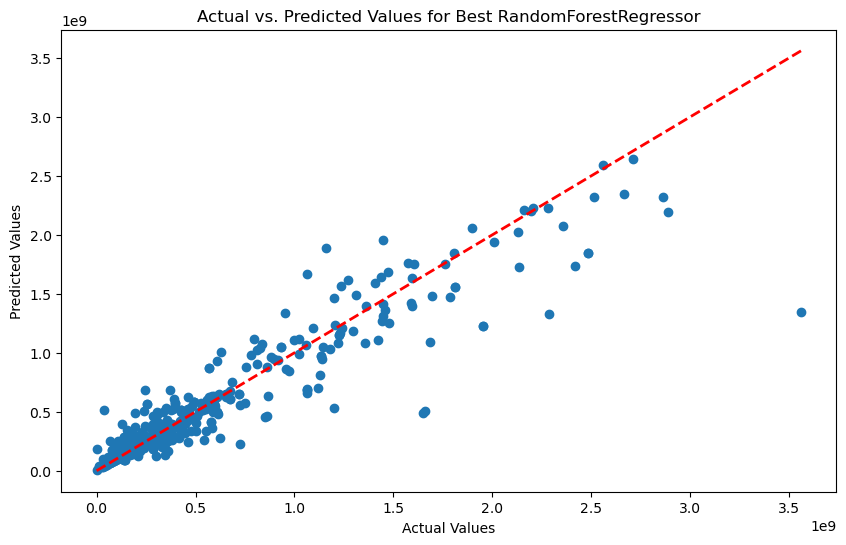

In [23]:
# plot actual results vs. predicted results
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_best)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted Values for Best RandomForestRegressor')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='red', linewidth=2)
plt.show()


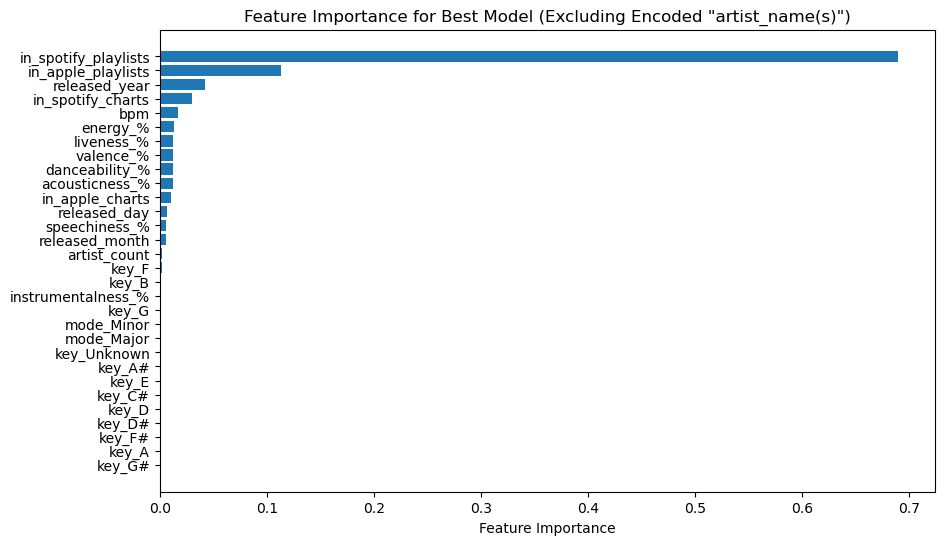

In [24]:
# get feature importances
feature_importances = best_rf_3_model.feature_importances_
feature_names = X_train_encoded.columns

# filter out features containing 'name' (artist_name(s) encoded category, too many values)
included_features = [feature for feature in feature_names if 'name' not in feature.lower()]
included_indices = [i for i, feature in enumerate(feature_names) if 'name' not in feature.lower()]
included_importances = feature_importances[included_indices]

# sort indices based on importances
sorted_idx = np.argsort(included_importances)

# plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_idx)), included_importances[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), [included_features[i] for i in sorted_idx])
plt.xlabel('Feature Importance')
plt.title('Feature Importance for Best Model (Excluding Encoded "artist_name(s)")')
plt.show()
